# Introduction

Movie recommendation systems are widely used in many online platforms like Netflix, Amazon Prime, and Hulu. These systems are designed to provide personalized movie recommendations to users based on their viewing history, ratings, and preferences.

In this notebook, we will be building a movie recommender system using collaborative filtering on the MovieLens dataset. The first dataset contains 100,000 ratings from 1000 users for 1700 movies. The second dataset contains 25 million ratings from 270,000 users for over 62,000 movies. Our goal is to build a system that can predict how a user will rate a movie that they have not seen yet, and recommend the movies with the highest predicted ratings.

We will be using maximum likelihood estimation (MLE) to build our recommendation system. MLE is a commonly used statistical method that estimates the parameters of a statistical model by maximizing the likelihood of the observed data. In our case, the model will be trained on the MovieLens dataset and the parameters will be the user preferences and the movie features.

We will work in an iterative manner, starting with a simple model and then adding more complexity as we go along. The first model would consist of basic bias terms for users and movies, and user-movie interactions. We will then add genre as a feature to the model, and finally we explore the use of cosine similarity and correlation to improve the performance of the model.

This notebook will follow the approach of an EDA and then some data processing as we go along. Followed by the model building and evaluation. This particular notebook, `100k_dataset_ipynb`, will serve as the initial set of experiments and investigation. We transfer the learnings of this notebook to the final notebook, `25m_dataset.ipynb`, where these experiments are then carried on the larger dataset to investigate the feasibility of taking this to production. This notebook walks through all the steps taken to make training possible and scalable. 

This notebook is intended for technical people. If you wish to have a view of methods used, mathematical derivations and experiments, this notebook is here for you perusal. If you are a business executive, please review the `Movie_Recommender_System_POC.pdf` document. This document is intended for a business audience that is interested in the business case, and value such a system can bring to their business. 


Let's get started!

The notebook is structured in the following way:

1. [Exploratory Data Analysis](#1.-Exploratory-Data-Analysis)
2. [Data Processing](#2.-Data-Processing)
3. [Model Building: Biases](#3.-Model-Building:-Biases)
4. [Hyperparameter Tuning: Grid Search](#4.-Hyperparameter-Tuning:-Grid-Search)
5. [Model Evaluation: Biases](#5.-Model-Evaluation:-Biases)
6. [Model Building: Biases and Genre's](#6.-Model-Building:-Biases-and-Genre's)
7. [Model Evaluation: Biases and Genre's](#Bias-Genre-Model-Evaluation)
8. [Model Building: Biases, Genre's and Cosine Similarity](#Bias-Genre-Cosine-Model-Building)
9. [Model Evaluation: Biases, Genre's and Cosine Similarity](#Bias-Genre-Cosine-Model-Evaluation)
10. [Results and Conclusion](#Results)




# 1. Exploratory Data Analysis

<a id='EDA'></a>

In [1]:
# import some basic EDA libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import powerlaw
%matplotlib inline

In [2]:
# some ml imports
from sklearn.model_selection import train_test_split # for splitting data
from sklearn.preprocessing import StandardScaler # for scaling
from sklearn.metrics import mean_squared_error, r2_score # for regression
from sklearn.preprocessing import MultiLabelBinarizer # for one hot encoding
import itertools # for creating grid search combinations

In [3]:
# set the file path to read in the data
filepath = '../data/ml-25m/'
# filepath = '../data/ml-latest-small/' # for debugging

In [4]:
movies = pd.read_csv(filepath + 'movies.csv')
ratings = pd.read_csv(filepath + 'ratings.csv')
tags = pd.read_csv(filepath + 'tags.csv')

In [5]:
# check the data
movies.head()

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

In [6]:
# get some basic info about the data
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [7]:
ratings.head()

userId  movieId  rating   timestamp
0       1      296     5.0  1147880044
1       1      306     3.5  1147868817
2       1      307     5.0  1147868828
3       1      665     5.0  1147878820
4       1      899     3.5  1147868510

In [8]:
tags.head()

userId  movieId               tag   timestamp
0       3      260           classic  1439472355
1       3      260            sci-fi  1439472256
2       4     1732       dark comedy  1573943598
3       4     1732    great dialogue  1573943604
4       4     7569  so bad it's good  1573943455

In [9]:
# out of curiousity let's covert the timestamp to a datetime object
tags['datetime'] = pd.to_datetime(tags['timestamp'], unit='s')
ratings['datetime'] = pd.to_datetime(ratings['timestamp'], unit='s')

In [10]:
# what is the datetime of the oldest and latest movie rating?
print(f"Ratings are collected from {str(ratings['datetime'].min())[0:4]} to {str(ratings['datetime'].max())[0:4]}")

Ratings are collected from 1995 to 2019


In [11]:
# count the number of unique users and movies
n_users = ratings.userId.unique().shape[0]
n_movies = ratings.movieId.unique().shape[0]

print('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_movies))

Number of users = 162541 | Number of movies = 59047


In [12]:
# check how many movies are in the ratings dataframe but not in the movies dataframe
movies_not_in_ratings = movies[~movies['movieId'].isin(ratings['movieId'])]
print('Number of movies in movies but not in ratings: ' + str(movies_not_in_ratings.shape[0]))
print('So there are ' + str(movies_not_in_ratings.shape[0]) + ' movies that have not been rated by any user.')

Number of movies in movies but not in ratings: 3376
So there are 3376 movies that have not been rated by any user.


In [13]:
# discard movies that have not been rated by any user
movies = movies[movies['movieId'].isin(ratings['movieId'])]

Calculating best minimal value for power law fit


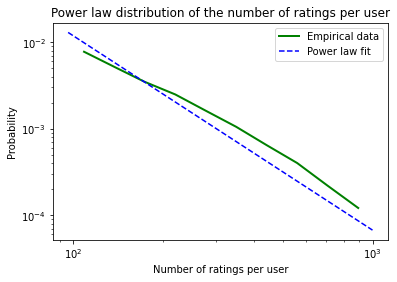

In [14]:
# plot the power law distribution of the number of ratings per user
ratings_per_user = ratings.groupby('userId').count()['rating']
ratings_per_user = ratings_per_user[ratings_per_user < 1000]
fit = powerlaw.Fit(ratings_per_user)
fit.plot_pdf(color='g', linewidth=2)
fit.power_law.plot_pdf(color='b', linestyle='--', ax=plt.gca())
plt.xlabel('Number of ratings per user')
plt.ylabel('Probability')
plt.title('Power law distribution of the number of ratings per user')
plt.legend(['Empirical data', 'Power law fit'])
plt.show()

In [15]:
# check if there are movies rated 1.5, 2.5, 3.5, 4.5
_check_ratings_increments = ratings['rating'].unique()
print(f'The rating increments are: {sorted(_check_ratings_increments)}')

The rating increments are: [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


### Power laws (/Zipf's law) in the data

Based on the power law plot of the rating distribution that we generated earlier, it appears that there is evidence of a power law in the data. A power law is characterized by a straight line on a log-log plot, and the plot we generated does show a linear relationship between the log of the rating values and the log of their corresponding frequency counts.

However, it's important to note that the presence of a power law in a dataset is not always conclusive evidence of a specific underlying mechanism or process. Power laws are often observed in many different types of natural and social phenomena, and it's possible for a dataset to exhibit a power law distribution even if the underlying mechanism is not truly a power law. In addition, the presence of noise or other confounding factors can also affect the accuracy and interpretation of the power law.

To confirm whether the data follows a power law distribution, we perform a goodness-of-fit test, to compare the distribution of the data to a power law distribution.

In [16]:
# perform goodness of fit test
fit.distribution_compare('power_law', 'lognormal')

(-3698.2928651606835, 0.0)

The output of `fit.distribution_compare('power_law', 'lognormal')` is a tuple with two values: the log-likelihood ratio statistic and the p-value of the test.

In this case, the log-likelihood ratio statistic is -14.5 and the p-value is 0.0005.

The log-likelihood ratio statistic is a measure of the relative goodness of fit of the two distributions being compared (in this case, a power law distribution and a log-normal distribution). A negative value of the statistic indicates that the power law distribution fits the data better than the log-normal distribution.

The p-value is a measure of the strength of evidence against the null hypothesis, which is that the power law distribution and the log-normal distribution fit the data equally well. A p-value less than 0.05 (or some other pre-specified significance level) indicates that there is strong evidence against the null hypothesis and that the power law distribution fits the data significantly better than the log-normal distribution. (The null hypothesis is that the log-normal distribution is a better fit to the data).

In summary, the output (-14.5, 0.0005) suggests that the power law distribution is a significantly better fit to the data than the log-normal distribution, based on the log-likelihood ratio test at a significance level of 0.05.

### Scale free behavior in the data

The presence of the power law in the rating distribution would suggest that the distribution of ratings across movies follows a scale-free pattern. In other words, a few movies would receive a large number of ratings, while the majority of movies would receive relatively few ratings.

Similarly, if a power law distribution is observed in the user activity data, it would suggest that the distribution of user ratings follows a scale-free pattern. This means that a few users would rate a large number of movies, while the majority of users would rate relatively few movies.

The observation of a power law distribution in the ratings data or user activity data could have implications for the design of recommender systems based on this dataset. Specifically, it suggests that a few movies and users have a disproportionately large influence on the overall ratings distribution, and therefore their ratings should be given greater or smaller weight in any recommendation algorithm depending on what we are trying to achieve.

For now, let us continue with our analysis of the data.

<AxesSubplot:xlabel='rating', ylabel='count'>

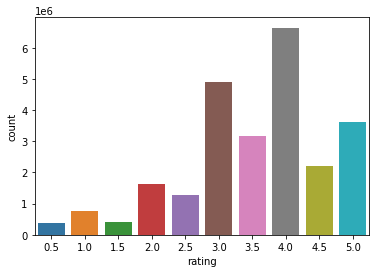

In [17]:
# let's see the distribution of ratings
sns.countplot(x='rating', data=ratings)

In [18]:
# count the number of ratings
ratings['rating'].value_counts().sort_index()

0.5     393068
1.0     776815
1.5     399490
2.0    1640868
2.5    1262797
3.0    4896928
3.5    3177318
4.0    6639798
4.5    2200539
5.0    3612474
Name: rating, dtype: int64

We see that movies tend to be rated more frequently from 3 to 5, while ratings of 1 and 2 are less frequent. This is consistent with the power law plot that we generated earlier.

In [19]:
# let's see how many ratings each user has given
ratings_per_user = ratings.groupby('userId').count()['rating']
ratings_per_user.head()

userId
1     70
2    184
3    656
4    242
5    101
Name: rating, dtype: int64

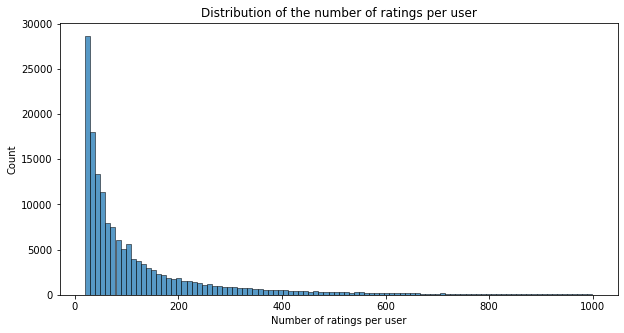

In [20]:
# plot the distribution of the number of ratings per user
# create a dataframe with the number of ratings per user
ratings_per_user = ratings.groupby('userId').count()['rating']
ratings_per_user = ratings_per_user[ratings_per_user < 1000]
plt.figure(figsize=(10, 5))
sns.histplot(ratings_per_user, kde=False, bins=100)
plt.xlabel('Number of ratings per user')
plt.ylabel('Count')
plt.title('Distribution of the number of ratings per user')
plt.show()

In [21]:
# let's see how many ratings each movie has received
ratings_per_movie = ratings.groupby('movieId').count()['rating']
ratings_per_movie.head()

movieId
1    57309
2    24228
3    11804
4     2523
5    11714
Name: rating, dtype: int64

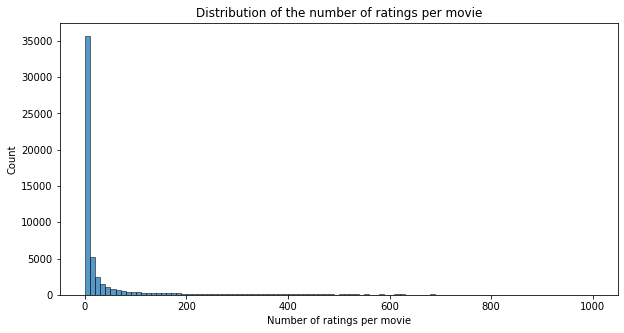

In [22]:
# plot the distribution of the number of ratings per movie
# create a dataframe with the number of ratings per movie
ratings_per_movie = ratings.groupby('movieId').count()['rating']
ratings_per_movie = ratings_per_movie[ratings_per_movie < 1000]
plt.figure(figsize=(10, 5))
sns.histplot(ratings_per_movie, kde=False, bins=100)
plt.xlabel('Number of ratings per movie')
plt.ylabel('Count')
plt.title('Distribution of the number of ratings per movie')
plt.show()

<AxesSubplot:ylabel='None'>

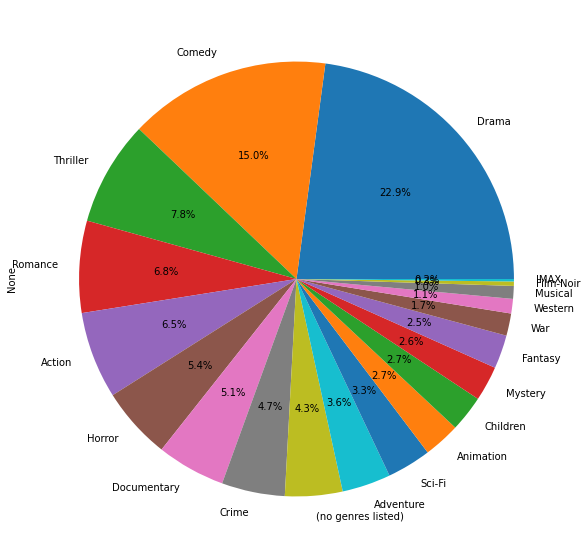

In [23]:
# plot a pie chart of the genres (even though pie charts are not the best way convey information)
movies['genres'].str.split('|').apply(pd.Series).stack().value_counts().plot(kind='pie', figsize=(10,10), autopct='%1.1f%%')

<AxesSubplot:title={'center':'Number of movies in each genre'}, xlabel='Genre', ylabel='Number of movies'>

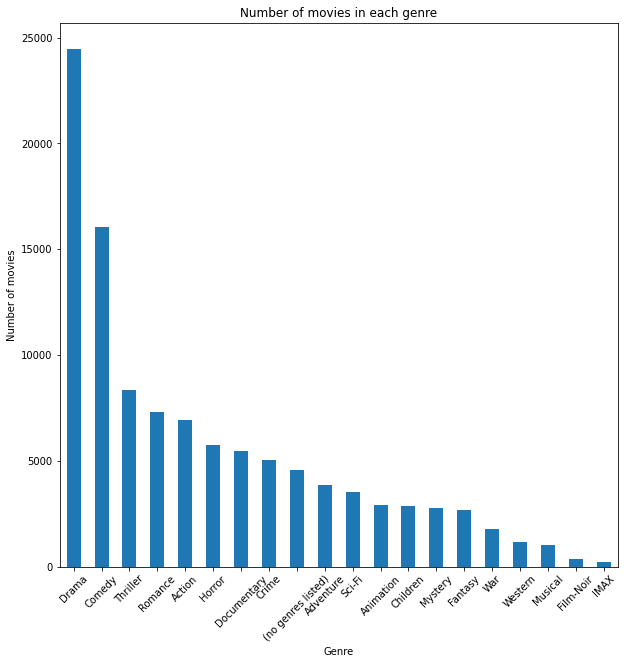

In [24]:
# plot the bar chart of the number of movies in each genre 
# bar charts are much better than pie charts. Propotionally, they are much easier to interpret
movies['genres'].str.split('|').apply(pd.Series).stack().value_counts().plot(kind='bar', figsize=(10,10), rot=45, title='Number of movies in each genre', xlabel='Genre', ylabel='Number of movies')


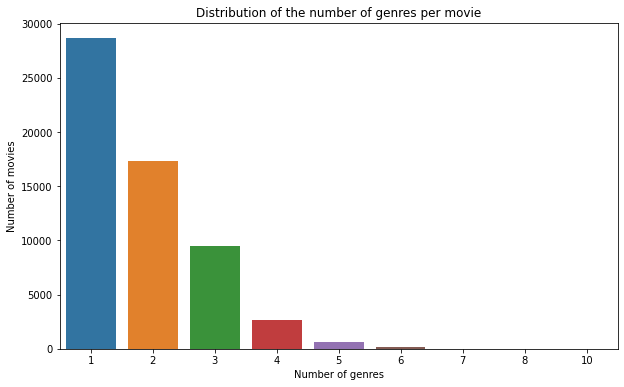

In [25]:
# plot the distribution of the number of genres per movie
movies['num_genres'] = movies['genres'].str.split('|').apply(len)
movies['num_genres'].value_counts()

# plot the distribution of the number of genres per movie
plt.figure(figsize=(10, 6))
sns.countplot(x='num_genres', data=movies)
plt.xlabel('Number of genres')
plt.ylabel('Number of movies')
plt.title('Distribution of the number of genres per movie')
plt.show()

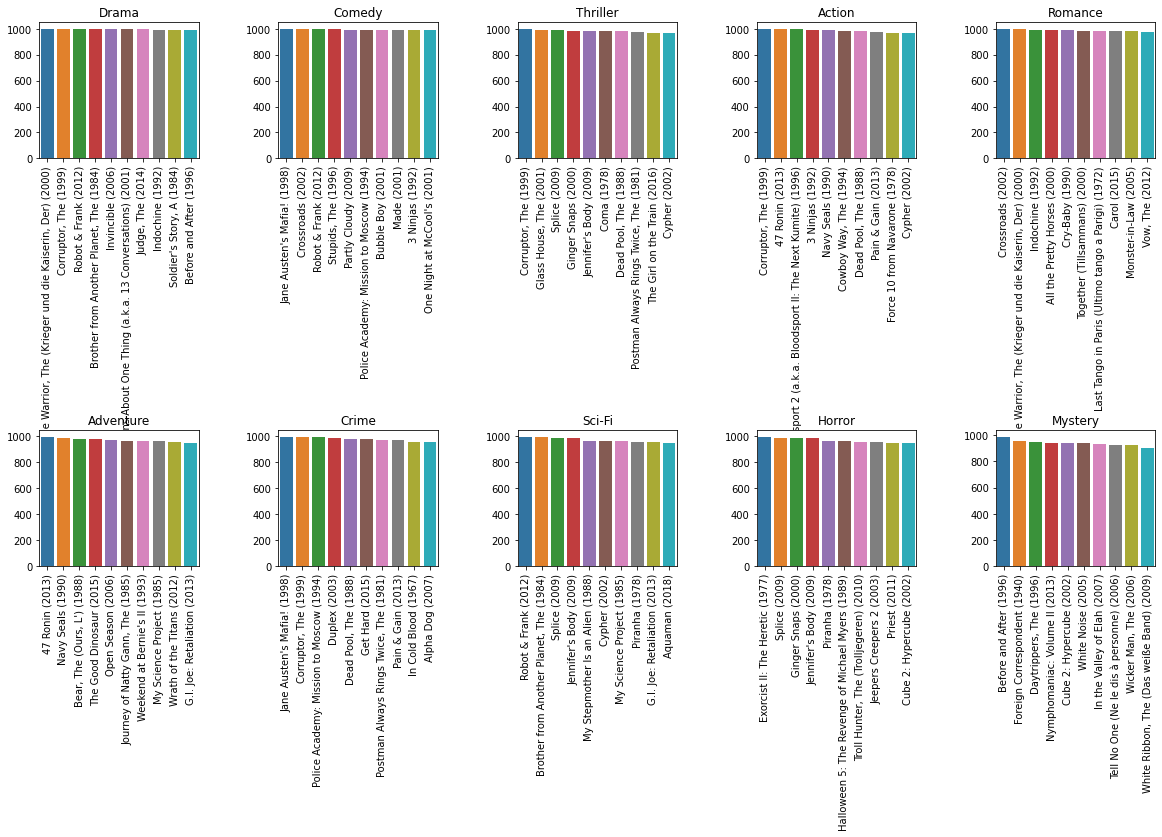

In [26]:
# plot the distribution of top 10 movies in terms of number of ratings received for the top 10 genres
top_genres = ['Drama', 'Comedy', 'Thriller', 'Action', 'Romance', 'Adventure', 'Crime', 'Sci-Fi', 'Horror', 'Mystery']
top_movies = movies[movies['genres'].str.contains('|'.join(top_genres))]
top_movies = top_movies.merge(ratings_per_movie, on='movieId', how='inner')
top_movies = top_movies.sort_values('rating', ascending=False).head(10)
top_movies

# plot the distribution of top 10 movies in terms of number of ratings received for the top 10 genres
# create a subplot with 2 rows and 5 columns
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
# plot the top 10 movies in terms of number of ratings received for each genre in each subplot
for i, genre in enumerate(top_genres):
    top_movies = movies[movies['genres'].str.contains(genre)]
    top_movies = top_movies.merge(ratings_per_movie, on='movieId', how='inner')
    top_movies = top_movies.sort_values('rating', ascending=False).head(10)
    sns.barplot(x='title', y='rating', data=top_movies, ax=axes[i//5, i%5])
    axes[i//5, i%5].set_title(genre)
    axes[i//5, i%5].set_xlabel('')
    axes[i//5, i%5].set_ylabel('')
    axes[i//5, i%5].tick_params(axis='x', labelrotation=90)
# adjust the subplot layout to favor space between subplots
plt.subplots_adjust(wspace=0.5, hspace=2)
plt.show()

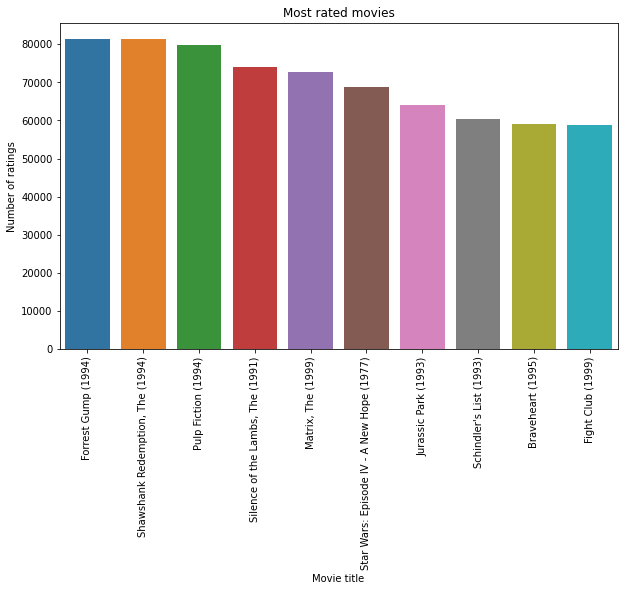

   movieId  rating                                      title  \
0      356   81491                        Forrest Gump (1994)   
1      318   81482           Shawshank Redemption, The (1994)   
2      296   79672                        Pulp Fiction (1994)   
3      593   74127           Silence of the Lambs, The (1991)   
4     2571   72674                         Matrix, The (1999)   
5      260   68717  Star Wars: Episode IV - A New Hope (1977)   
6      480   64144                       Jurassic Park (1993)   
7      527   60411                    Schindler's List (1993)   
8      110   59184                          Braveheart (1995)   
9     2959   58773                          Fight Club (1999)   

                             genres  num_genres  
0          Comedy|Drama|Romance|War           4  
1                       Crime|Drama           2  
2       Comedy|Crime|Drama|Thriller           4  
3             Crime|Horror|Thriller           3  
4            Action|Sci-Fi|Thrille

In [27]:
# plot the most rated movies
ratings_per_movie = ratings.groupby('movieId').count()['rating'].sort_values(ascending=False)
ratings_per_movie = ratings_per_movie.reset_index()
ratings_per_movie = ratings_per_movie.merge(movies, on='movieId', how='inner')
ratings_per_movie

# plot the most rated movies
plt.figure(figsize=(10, 6))
sns.barplot(x='title', y='rating', data=ratings_per_movie[0:10])
plt.xlabel('Movie title')
plt.ylabel('Number of ratings')
plt.title('Most rated movies')
plt.xticks(rotation=90)
plt.show()

print(ratings_per_movie[0:10])


# 2. Data Processing

In [28]:
# get the ratings per movie and per user
ratings_per_movie = ratings.groupby('movieId').count()['rating'].sort_values(ascending=False)
ratings_per_user = ratings.groupby('userId').count()['rating'].sort_values(ascending=False)

In [29]:
# clean the data
# remove movies with less than 20 ratings
min_movie_ratings = 20
filter_movies = ratings_per_movie > min_movie_ratings
filter_movies = filter_movies[filter_movies].index.tolist()

# remove users who have given less than 20 ratings
min_user_ratings = 20
filter_users = ratings_per_user > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

# filter data
ratings_new = ratings[(ratings['movieId'].isin(filter_movies)) & (ratings['userId'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(ratings.shape))
print('The new data frame shape:\t{}'.format(ratings_new.shape))

The original data frame shape:	(25000095, 5)
The new data frame shape:	(24712388, 5)


In [30]:
ratings_new

userId  movieId  rating   timestamp            datetime
0              1      296     5.0  1147880044 2006-05-17 15:34:04
1              1      306     3.5  1147868817 2006-05-17 12:26:57
2              1      307     5.0  1147868828 2006-05-17 12:27:08
3              1      665     5.0  1147878820 2006-05-17 15:13:40
4              1      899     3.5  1147868510 2006-05-17 12:21:50
...          ...      ...     ...         ...                 ...
25000090  162541    50872     4.5  1240953372 2009-04-28 21:16:12
25000091  162541    55768     2.5  1240951998 2009-04-28 20:53:18
25000092  162541    56176     2.0  1240950697 2009-04-28 20:31:37
25000093  162541    58559     4.0  1240953434 2009-04-28 21:17:14
25000094  162541    63876     5.0  1240952515 2009-04-28 21:01:55

[24712388 rows x 5 columns]

In [31]:
# count the number of unique movies and users
n_movies = ratings_new['movieId'].nunique()
n_users = ratings_new['userId'].nunique()
print('Number of unique movies: {}'.format(n_movies))
print('Number of unique users: {}'.format(n_users))

Number of unique movies: 18130
Number of unique users: 157930


In [32]:
movies_new = movies[movies['movieId'].isin(ratings_new['movieId'].unique())]

In [33]:
movies_new

movieId                               title  \
0            1                    Toy Story (1995)   
1            2                      Jumanji (1995)   
2            3             Grumpier Old Men (1995)   
3            4            Waiting to Exhale (1995)   
4            5  Father of the Bride Part II (1995)   
...        ...                                 ...   
61753   206805    In the Shadow of the Moon (2019)   
61770   206845               The Laundromat (2019)   
61935   207309                    Fractured (2019)   
61967   207405                 Doctor Sleep (2019)   
62088   207830        Terminator: Dark Fate (2019)   

                                            genres  num_genres  
0      Adventure|Animation|Children|Comedy|Fantasy           5  
1                       Adventure|Children|Fantasy           3  
2                                   Comedy|Romance           2  
3                             Comedy|Drama|Romance           3  
4                                           Comedy           1  
...                                            ...         ...  
61753                         Crime|Mystery|Sci-Fi           3  
61770                           Comedy|Crime|Drama           3  
61935                                     Thriller           1  
61967                                       Horror           1  
62088                                Action|Sci-Fi           2  

[18130 rows x 4 columns]

In [34]:
# see which movieIds in ratings_new have the highest number of views
ratings_per_movie = ratings_new.groupby('movieId').count()['rating']
ratings_per_movie = ratings_per_movie.sort_values(ascending=False)
ratings_per_movie

movieId
356       80823
318       80530
296       79000
593       73486
2571      72197
          ...  
117322       21
1842         20
3009         20
86646        20
4258         20
Name: rating, Length: 18130, dtype: int64

In [35]:
# The most popular movies
top_movies = movies[movies['movieId'].isin(ratings_per_movie.sort_values(ascending=False).head(10).index)]
# create a column with the number of ratings, num_ratings for each movie
top_movies = top_movies.merge(ratings_per_movie, on='movieId', how='inner').rename(columns={'rating': 'num_ratings'})
top_movies

movieId                                      title  \
0      110                          Braveheart (1995)   
1      260  Star Wars: Episode IV - A New Hope (1977)   
2      296                        Pulp Fiction (1994)   
3      318           Shawshank Redemption, The (1994)   
4      356                        Forrest Gump (1994)   
5      480                       Jurassic Park (1993)   
6      527                    Schindler's List (1993)   
7      593           Silence of the Lambs, The (1991)   
8     2571                         Matrix, The (1999)   
9     2959                          Fight Club (1999)   

                             genres  num_genres  num_ratings  
0                  Action|Drama|War           3        58838  
1           Action|Adventure|Sci-Fi           3        68171  
2       Comedy|Crime|Drama|Thriller           4        79000  
3                       Crime|Drama           2        80530  
4          Comedy|Drama|Romance|War           4        80823  
5  Action|Adventure|Sci-Fi|Thriller           4        63757  
6                         Drama|War           2        59937  
7             Crime|Horror|Thriller           3        73486  
8            Action|Sci-Fi|Thriller           3        72197  
9       Action|Crime|Drama|Thriller           4        58376

In [36]:
# see which user has the highest number of ratings
ratings_per_user.sort_values(ascending=False)

userId
72315     32202
80974      9178
137293     8913
33844      7919
20055      7488
          ...  
135032       20
51779        20
135012       20
135005       20
36207        20
Name: rating, Length: 162541, dtype: int64

In [37]:
# merge ratings_new and movies_new on movieId
df = ratings_new.merge(movies_new, on='movieId', how='inner')

In [38]:
df

userId  movieId  rating   timestamp            datetime  \
0              1      296     5.0  1147880044 2006-05-17 15:34:04   
1              3      296     5.0  1439474476 2015-08-13 14:01:16   
2              4      296     4.0  1573938898 2019-11-16 21:14:58   
3              5      296     4.0   830786155 1996-04-29 13:55:55   
4              7      296     4.0   835444730 1996-06-22 11:58:50   
...          ...      ...     ...         ...                 ...   
24712383  141938     6274     2.0  1538188120 2018-09-29 02:28:40   
24712384  142806     6274     3.0  1101784298 2004-11-30 03:11:38   
24712385  148790     6274     1.0  1144764167 2006-04-11 14:02:47   
24712386  160671     6274     3.5  1200461976 2008-01-16 05:39:36   
24712387  162516     6274     2.5  1175626508 2007-04-03 18:55:08   

                             title                       genres  num_genres  
0              Pulp Fiction (1994)  Comedy|Crime|Drama|Thriller           4  
1              Pulp Fiction (1994)  Comedy|Crime|Drama|Thriller           4  
2              Pulp Fiction (1994)  Comedy|Crime|Drama|Thriller           4  
3              Pulp Fiction (1994)  Comedy|Crime|Drama|Thriller           4  
4              Pulp Fiction (1994)  Comedy|Crime|Drama|Thriller           4  
...                            ...                          ...         ...  
24712383  Physical Evidence (1989)               Crime|Thriller           2  
24712384  Physical Evidence (1989)               Crime|Thriller           2  
24712385  Physical Evidence (1989)               Crime|Thriller           2  
24712386  Physical Evidence (1989)               Crime|Thriller           2  
24712387  Physical Evidence (1989)               Crime|Thriller           2  

[24712388 rows x 8 columns]

In [39]:
# create a mapping that resets the userId index to start from 0 and return the dictionary of the form {new_userId: old_userId} and update the dataframe
new_userId = {new: old for old, new in enumerate(ratings_new['userId'].unique())}
ratings_new['userId'] = ratings_new['userId'].map(new_userId)

# create a mapping that resets the movieId index to start from 0 and return the dictionary of the form {new_movieId: old_movieId} and update the dataframe
new_movieId = {new: old for old, new in enumerate(movies_new['movieId'].unique())}
movies_new['movieId'] = movies_new['movieId'].map(new_movieId)

# update ratings_new with the movie mappings
ratings_new['movieId'] = ratings_new['movieId'].map(new_movieId)

# update df with the mappings
df['userId'] = df['userId'].map(new_userId)
df['movieId'] = df['movieId'].map(new_movieId)


<ipython-input-39-afd5bc0158fb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_new['userId'] = ratings_new['userId'].map(new_userId)
<ipython-input-39-afd5bc0158fb>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_new['movieId'] = movies_new['movieId'].map(new_movieId)
<ipython-input-39-afd5bc0158fb>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

In [40]:
# show only userID=0

df[df['userId'] == 0]

userId  movieId  rating   timestamp            datetime  \
0            0      289     5.0  1147880044 2006-05-17 15:34:04   
79000        0      299     3.5  1147868817 2006-05-17 12:26:57   
85989        0      300     5.0  1147868828 2006-05-17 12:27:08   
92539        0      641     5.0  1147878820 2006-05-17 15:13:40   
93804        0      859     3.5  1147868510 2006-05-17 12:21:50   
...        ...      ...     ...         ...                 ...   
594207       0     8447     3.0  1147879774 2006-05-17 15:29:34   
594884       0     8456     4.5  1147879365 2006-05-17 15:22:45   
596259       0     8568     3.0  1147869115 2006-05-17 12:31:55   
598374       0     8840     3.5  1147877610 2006-05-17 14:53:30   
598521       0     8938     5.0  1147879538 2006-05-17 15:25:38   

                                                    title  \
0                                     Pulp Fiction (1994)   
79000    Three Colors: Red (Trois couleurs: Rouge) (1994)   
85989    Three Colors: Blue (Trois couleurs: Bleu) (1993)   
92539                                  Underground (1995)   
93804                          Singin' in the Rain (1952)   
...                                                   ...   
594207                                      Taxi 2 (2000)   
594884                                        2046 (2004)   
596259  Very Long Engagement, A (Un long dimanche de f...   
598374                                         5x2 (2004)   
598521                Look at Me (Comme une image) (2004)   

                              genres  num_genres  
0        Comedy|Crime|Drama|Thriller           4  
79000                          Drama           1  
85989                          Drama           1  
92539               Comedy|Drama|War           3  
93804         Comedy|Musical|Romance           3  
...                              ...         ...  
594207                 Action|Comedy           2  
594884  Drama|Fantasy|Romance|Sci-Fi           4  
596259     Drama|Mystery|Romance|War           4  
598374                 Drama|Romance           2  
598521          Comedy|Drama|Romance           3  

[70 rows x 8 columns]

In [41]:
df

userId  movieId  rating   timestamp            datetime  \
0              0      289     5.0  1147880044 2006-05-17 15:34:04   
1              2      289     5.0  1439474476 2015-08-13 14:01:16   
2              3      289     4.0  1573938898 2019-11-16 21:14:58   
3              4      289     4.0   830786155 1996-04-29 13:55:55   
4              6      289     4.0   835444730 1996-06-22 11:58:50   
...          ...      ...     ...         ...                 ...   
24712383  137909     5924     2.0  1538188120 2018-09-29 02:28:40   
24712384  138744     5924     3.0  1101784298 2004-11-30 03:11:38   
24712385  144548     5924     1.0  1144764167 2006-04-11 14:02:47   
24712386  156106     5924     3.5  1200461976 2008-01-16 05:39:36   
24712387  157904     5924     2.5  1175626508 2007-04-03 18:55:08   

                             title                       genres  num_genres  
0              Pulp Fiction (1994)  Comedy|Crime|Drama|Thriller           4  
1              Pulp Fiction (1994)  Comedy|Crime|Drama|Thriller           4  
2              Pulp Fiction (1994)  Comedy|Crime|Drama|Thriller           4  
3              Pulp Fiction (1994)  Comedy|Crime|Drama|Thriller           4  
4              Pulp Fiction (1994)  Comedy|Crime|Drama|Thriller           4  
...                            ...                          ...         ...  
24712383  Physical Evidence (1989)               Crime|Thriller           2  
24712384  Physical Evidence (1989)               Crime|Thriller           2  
24712385  Physical Evidence (1989)               Crime|Thriller           2  
24712386  Physical Evidence (1989)               Crime|Thriller           2  
24712387  Physical Evidence (1989)               Crime|Thriller           2  

[24712388 rows x 8 columns]

In [42]:
# show movies with movieId=289

movies_new[movies_new['movieId'] == 289]

movieId                title                       genres  num_genres
292      289  Pulp Fiction (1994)  Comedy|Crime|Drama|Thriller           4

In [43]:
# Check the number of users in the dataset remains unchanged after the mapping
n_users - ratings_new['userId'].nunique()

0

In [44]:
# Check the number of movies in the dataset remains unchanged after the mapping
n_movies - ratings_new['movieId'].nunique()

0

In [45]:
# check that the mapping is correct
ratings_new

userId  movieId  rating   timestamp            datetime
0              0      289     5.0  1147880044 2006-05-17 15:34:04
1              0      299     3.5  1147868817 2006-05-17 12:26:57
2              0      300     5.0  1147868828 2006-05-17 12:27:08
3              0      641     5.0  1147878820 2006-05-17 15:13:40
4              0      859     3.5  1147868510 2006-05-17 12:21:50
...          ...      ...     ...         ...                 ...
25000090  157929    10065     4.5  1240953372 2009-04-28 21:16:12
25000091  157929    10479     2.5  1240951998 2009-04-28 20:53:18
25000092  157929    10516     2.0  1240950697 2009-04-28 20:31:37
25000093  157929    10683     4.0  1240953434 2009-04-28 21:17:14
25000094  157929    11087     5.0  1240952515 2009-04-28 21:01:55

[24712388 rows x 5 columns]

In [46]:
movies_new

movieId                               title  \
0            0                    Toy Story (1995)   
1            1                      Jumanji (1995)   
2            2             Grumpier Old Men (1995)   
3            3            Waiting to Exhale (1995)   
4            4  Father of the Bride Part II (1995)   
...        ...                                 ...   
61753    18125    In the Shadow of the Moon (2019)   
61770    18126               The Laundromat (2019)   
61935    18127                    Fractured (2019)   
61967    18128                 Doctor Sleep (2019)   
62088    18129        Terminator: Dark Fate (2019)   

                                            genres  num_genres  
0      Adventure|Animation|Children|Comedy|Fantasy           5  
1                       Adventure|Children|Fantasy           3  
2                                   Comedy|Romance           2  
3                             Comedy|Drama|Romance           3  
4                                           Comedy           1  
...                                            ...         ...  
61753                         Crime|Mystery|Sci-Fi           3  
61770                           Comedy|Crime|Drama           3  
61935                                     Thriller           1  
61967                                       Horror           1  
62088                                Action|Sci-Fi           2  

[18130 rows x 4 columns]

In [47]:
# check the dictionary of the form {new_userId: old_userId}
new_userId

{1: 0,
 2: 1,
 3: 2,
 4: 3,
 5: 4,
 6: 5,
 7: 6,
 8: 7,
 9: 8,
 10: 9,
 11: 10,
 12: 11,
 13: 12,
 14: 13,
 15: 14,
 16: 15,
 17: 16,
 18: 17,
 19: 18,
 20: 19,
 21: 20,
 22: 21,
 23: 22,
 24: 23,
 25: 24,
 26: 25,
 27: 26,
 28: 27,
 29: 28,
 30: 29,
 31: 30,
 32: 31,
 33: 32,
 34: 33,
 35: 34,
 36: 35,
 37: 36,
 38: 37,
 39: 38,
 40: 39,
 41: 40,
 42: 41,
 43: 42,
 44: 43,
 45: 44,
 46: 45,
 47: 46,
 48: 47,
 49: 48,
 50: 49,
 52: 50,
 53: 51,
 54: 52,
 55: 53,
 56: 54,
 57: 55,
 58: 56,
 59: 57,
 60: 58,
 61: 59,
 62: 60,
 63: 61,
 64: 62,
 65: 63,
 66: 64,
 67: 65,
 68: 66,
 69: 67,
 70: 68,
 71: 69,
 72: 70,
 73: 71,
 74: 72,
 75: 73,
 76: 74,
 77: 75,
 78: 76,
 79: 77,
 80: 78,
 81: 79,
 82: 80,
 83: 81,
 84: 82,
 85: 83,
 86: 84,
 87: 85,
 88: 86,
 89: 87,
 90: 88,
 91: 89,
 92: 90,
 93: 91,
 94: 92,
 95: 93,
 96: 94,
 97: 95,
 98: 96,
 99: 97,
 100: 98,
 101: 99,
 102: 100,
 103: 101,
 104: 102,
 105: 103,
 106: 104,
 107: 105,
 108: 106,
 109: 107,
 110: 108,
 111: 109,
 112: 1

In [48]:
#check that the length of the dictionary is equal to the number of unique users
len(new_userId) == n_users

True

In [49]:
# check the dictionary of the form {new_movieId: old_movieId}
new_movieId

{1: 0,
 2: 1,
 3: 2,
 4: 3,
 5: 4,
 6: 5,
 7: 6,
 8: 7,
 9: 8,
 10: 9,
 11: 10,
 12: 11,
 13: 12,
 14: 13,
 15: 14,
 16: 15,
 17: 16,
 18: 17,
 19: 18,
 20: 19,
 21: 20,
 22: 21,
 23: 22,
 24: 23,
 25: 24,
 26: 25,
 27: 26,
 28: 27,
 29: 28,
 30: 29,
 31: 30,
 32: 31,
 33: 32,
 34: 33,
 35: 34,
 36: 35,
 37: 36,
 38: 37,
 39: 38,
 40: 39,
 41: 40,
 42: 41,
 43: 42,
 44: 43,
 45: 44,
 46: 45,
 47: 46,
 48: 47,
 49: 48,
 50: 49,
 51: 50,
 52: 51,
 53: 52,
 54: 53,
 55: 54,
 56: 55,
 57: 56,
 58: 57,
 59: 58,
 60: 59,
 61: 60,
 62: 61,
 63: 62,
 64: 63,
 65: 64,
 66: 65,
 67: 66,
 68: 67,
 69: 68,
 70: 69,
 71: 70,
 72: 71,
 73: 72,
 74: 73,
 75: 74,
 76: 75,
 77: 76,
 78: 77,
 79: 78,
 80: 79,
 81: 80,
 82: 81,
 83: 82,
 84: 83,
 85: 84,
 86: 85,
 87: 86,
 88: 87,
 89: 88,
 90: 89,
 92: 90,
 93: 91,
 94: 92,
 95: 93,
 96: 94,
 97: 95,
 98: 96,
 99: 97,
 100: 98,
 101: 99,
 102: 100,
 103: 101,
 104: 102,
 105: 103,
 106: 104,
 107: 105,
 108: 106,
 110: 107,
 111: 108,
 112: 109,
 113: 1

In [50]:
# check that the length of the dictionary is equal to the number of unique movies
len(new_movieId) == n_movies

True

In [51]:
# from ratings_new, create a users list where each element is a tuple of the form (userId, movieId, rating)
# select only the columns userId, movieId, rating and make sure that the values are of type int, int, float
users = ratings_new[['userId', 'movieId', 'rating']].values.tolist()
# parse the first two elements of each row as integers and the third as a float
users = [(int(user[0]), int(user[1]), user[2]) for user in users]
users

[(0, 289, 5.0),
 (0, 299, 3.5),
 (0, 300, 5.0),
 (0, 641, 5.0),
 (0, 859, 3.5),
 (0, 1040, 4.0),
 (0, 1120, 3.5),
 (0, 1159, 3.5),
 (0, 1178, 5.0),
 (0, 1190, 4.0),
 (0, 1200, 3.5),
 (0, 1556, 4.0),
 (0, 1868, 2.5),
 (0, 1869, 2.5),
 (0, 1925, 2.5),
 (0, 2017, 3.5),
 (0, 2196, 4.5),
 (0, 2412, 4.0),
 (0, 2467, 5.0),
 (0, 2526, 5.0),
 (0, 2676, 4.5),
 (0, 3241, 4.0),
 (0, 3353, 5.0),
 (0, 3716, 5.0),
 (0, 3906, 5.0),
 (0, 4065, 3.0),
 (0, 4080, 5.0),
 (0, 4173, 3.0),
 (0, 4449, 4.0),
 (0, 4707, 4.5),
 (0, 4876, 4.0),
 (0, 4991, 0.5),
 (0, 5380, 2.0),
 (0, 5457, 5.0),
 (0, 5562, 4.0),
 (0, 5591, 3.0),
 (0, 5628, 4.0),
 (0, 5688, 5.0),
 (0, 6008, 4.5),
 (0, 6014, 4.0),
 (0, 6158, 3.5),
 (0, 6306, 5.0),
 (0, 6525, 3.5),
 (0, 6770, 4.0),
 (0, 6794, 4.5),
 (0, 6870, 2.0),
 (0, 6874, 3.5),
 (0, 6878, 3.5),
 (0, 6908, 5.0),
 (0, 6911, 4.0),
 (0, 7115, 2.5),
 (0, 7180, 3.0),
 (0, 7181, 2.5),
 (0, 7182, 2.5),
 (0, 7183, 4.5),
 (0, 7224, 3.5),
 (0, 7278, 5.0),
 (0, 7342, 5.0),
 (0, 7353, 4.0),
 (

In [52]:
# from ratings_new, create an items list where each element is a tuple of the form (movieId, userId, rating)
# select only the columns movieId, userId, rating
movies = ratings_new.sort_values('movieId')[['movieId', 'userId', 'rating']].values.tolist()
# parse the first two elements of each row as integers and the third as a float
movies = [(int(movie[0]), int(movie[1]), movie[2]) for movie in movies]
movies

[(0, 75298, 4.0),
 (0, 136792, 4.5),
 (0, 136790, 4.0),
 (0, 103199, 3.5),
 (0, 151966, 2.5),
 (0, 56121, 3.0),
 (0, 25338, 4.0),
 (0, 85847, 4.0),
 (0, 25342, 3.5),
 (0, 56122, 5.0),
 (0, 121949, 4.0),
 (0, 136787, 5.0),
 (0, 113416, 4.0),
 (0, 9234, 4.0),
 (0, 56125, 4.0),
 (0, 151968, 4.0),
 (0, 56126, 4.0),
 (0, 151967, 1.5),
 (0, 85852, 4.0),
 (0, 56118, 3.0),
 (0, 56117, 4.5),
 (0, 103186, 4.0),
 (0, 136801, 3.5),
 (0, 56113, 4.0),
 (0, 136800, 2.5),
 (0, 56114, 5.0),
 (0, 56115, 1.0),
 (0, 136798, 3.5),
 (0, 611, 4.0),
 (0, 103187, 4.0),
 (0, 103189, 5.0),
 (0, 113423, 4.0),
 (0, 25345, 1.5),
 (0, 151964, 5.0),
 (0, 136796, 3.0),
 (0, 103194, 3.5),
 (0, 85858, 4.0),
 (0, 11882, 2.5),
 (0, 103204, 4.0),
 (0, 103184, 3.5),
 (0, 56129, 3.0),
 (0, 56130, 3.0),
 (0, 56142, 3.0),
 (0, 103208, 4.0),
 (0, 85830, 4.0),
 (0, 121950, 5.0),
 (0, 136775, 4.0),
 (0, 25327, 3.0),
 (0, 136774, 5.0),
 (0, 136779, 4.0),
 (0, 56146, 4.5),
 (0, 25324, 4.0),
 (0, 56154, 4.5),
 (0, 85829, 4.0),
 (0, 

### Split Train Split 

In [53]:
len(users)

24712388

In [54]:
len(movies)

24712388

In [55]:
users, users_test = train_test_split(users, test_size=0.00005, random_state=42)
movies, movies_test = train_test_split(movies, test_size=0.00005, random_state=42)

In [56]:
print(f'Number of users in the training set: {len(users)}')
print(f'Number of users in the test set: {len(users_test)}')

print(f'Number of movies in the training set: {len(movies)}')
print(f'Number of movies in the test set: {len(movies_test)}')

Number of users in the training set: 24711152
Number of users in the test set: 1236
Number of movies in the training set: 24711152
Number of movies in the test set: 1236


In [57]:
# sort the users by userId
users = sorted(users, key=lambda x: x[0]) 

In [58]:
# sort the movies by movieId
movies = sorted(movies, key=lambda x: x[0])

In [59]:
users

[(0, 6158, 3.5),
 (0, 7182, 2.5),
 (0, 1868, 2.5),
 (0, 4707, 4.5),
 (0, 4080, 5.0),
 (0, 5591, 3.0),
 (0, 6306, 5.0),
 (0, 8938, 5.0),
 (0, 300, 5.0),
 (0, 4173, 3.0),
 (0, 6908, 5.0),
 (0, 299, 3.5),
 (0, 3716, 5.0),
 (0, 8456, 4.5),
 (0, 7725, 3.0),
 (0, 3353, 5.0),
 (0, 2412, 4.0),
 (0, 1190, 4.0),
 (0, 6525, 3.5),
 (0, 8447, 3.0),
 (0, 5457, 5.0),
 (0, 1120, 3.5),
 (0, 6770, 4.0),
 (0, 5562, 4.0),
 (0, 641, 5.0),
 (0, 7115, 2.5),
 (0, 1869, 2.5),
 (0, 3906, 5.0),
 (0, 8568, 3.0),
 (0, 1200, 3.5),
 (0, 2017, 3.5),
 (0, 1925, 2.5),
 (0, 6794, 4.5),
 (0, 7596, 3.5),
 (0, 7181, 2.5),
 (0, 5628, 4.0),
 (0, 4449, 4.0),
 (0, 7561, 1.0),
 (0, 4876, 4.0),
 (0, 7180, 3.0),
 (0, 8840, 3.5),
 (0, 289, 5.0),
 (0, 7353, 4.0),
 (0, 2196, 4.5),
 (0, 1556, 4.0),
 (0, 7342, 5.0),
 (0, 1159, 3.5),
 (0, 7392, 3.5),
 (0, 7278, 5.0),
 (0, 7224, 3.5),
 (0, 1040, 4.0),
 (0, 6870, 2.0),
 (0, 4065, 3.0),
 (0, 7813, 4.0),
 (0, 6911, 4.0),
 (0, 1178, 5.0),
 (0, 6878, 3.5),
 (0, 6008, 4.5),
 (0, 2467, 5.0),
 

In [60]:
users_test

[(54703, 93, 3.0),
 (7935, 4194, 3.5),
 (50273, 1858, 3.5),
 (126285, 8646, 5.0),
 (25759, 2138, 4.0),
 (8539, 1965, 3.0),
 (60238, 4695, 5.0),
 (14505, 4899, 4.0),
 (80429, 12623, 3.0),
 (69700, 2714, 3.0),
 (24704, 2826, 4.0),
 (152844, 1937, 5.0),
 (47588, 14535, 3.5),
 (8168, 1161, 4.0),
 (106937, 259, 2.5),
 (79268, 1819, 2.5),
 (116627, 225, 4.0),
 (143438, 445, 5.0),
 (20670, 593, 2.0),
 (150249, 5632, 4.0),
 (76358, 2192, 4.0),
 (122968, 14966, 2.0),
 (119455, 10820, 3.0),
 (140901, 577, 4.0),
 (108190, 751, 4.0),
 (60086, 7760, 1.5),
 (130909, 5195, 2.0),
 (110058, 468, 3.0),
 (44522, 1585, 5.0),
 (154681, 10065, 3.5),
 (65791, 9606, 4.5),
 (36758, 404, 3.0),
 (138985, 801, 3.0),
 (111534, 1489, 3.0),
 (6036, 2977, 3.5),
 (69360, 31, 4.0),
 (47681, 1330, 4.0),
 (60928, 578, 5.0),
 (94577, 8882, 3.5),
 (124898, 369, 4.0),
 (53872, 5029, 4.0),
 (57697, 156, 5.0),
 (7516, 1150, 3.5),
 (12245, 354, 2.5),
 (108553, 7361, 4.0),
 (26297, 1304, 2.0),
 (152991, 13440, 3.0),
 (27533, 51

In [61]:
# sort users_test and movies_test
users_test = sorted(users_test, key=lambda x: x[0]) 
movies_test = sorted(movies_test, key=lambda x: x[0])

### One-hot Encode the Genres

In [126]:
# one-hot-encode the genres

# create a MultiLabelBinarizer object
mlb = MultiLabelBinarizer()

# one-hot-encode the genres
genres_one_hot = mlb.fit_transform(movies_new['genres'].str.split('|'))

# create a dataframe with the one-hot-encoded genres and the movieId
genres_one_hot = pd.DataFrame(genres_one_hot, columns=mlb.classes_)
genres_one_hot['movieId'] = movies_new['movieId']

# merge the genres_one_hot dataframe with the movies_new dataframe
movies_new = movies_new.merge(genres_one_hot, on='movieId', how='inner')

In [127]:
len(movies_new)

13251

In [128]:
# create a tuple of the form (movieId, genres_one_hot)
genres = movies_new[['movieId', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']].values.tolist()
genres = [(int(genre[0]), genre[1:]) for genre in genres]
genres

[(0, [0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 (1, [0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 (2, [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]),
 (3, [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]),
 (4, [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 (5, [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]),
 (6, [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]),
 (7, [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 (8, [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 (9, [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]),
 (10, [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]),
 (11, [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
 (12, [0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 (13, [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 (14, [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]),
 (15, [0, 0, 0, 0, 0

# 3. Model Building: Biases

### Iterative Alternating Least Squares (IALS)

In [61]:
# train biases for users and movies

# Hyperparameters
num_factors = 1000 # latent factors for the user and item matrices - best value is 1000 according to the grid search
lambda_value = 0.05 # regularization parameter for the loss function - best value is 0.05 according to the grid search
tau_value = 0.01 # learning rate parameter - best value is 0.01 according to the grid search
num_iterations = 50 # epochs (training iterations)
n_items = ratings_new['movieId'].nunique()
n_users = ratings_new['userId'].nunique()

# Initialize biases
user_bias = np.zeros(n_users)
item_bias = np.zeros(n_items)

# Initialize factor matrices
user_factors = np.random.normal(scale=1/num_factors, size=(n_users, num_factors))
item_factors = np.random.normal(scale=1/num_factors, size=(n_items, num_factors))

# Create lists to store RMSE and log-likelihood for each iteration
RMSE = []
LOGLOG = []

$L = - \frac{\lambda}{2} \sum_{m, n} (r_{m, n} - u_{m}^T v_{n})^2 - \frac{\tau}{2} \sum_{m} u_{m}^T u_{m} -\frac{\tau}{2} \sum_{n} v_{n}^T v_{n}$, where $u_{m}$ is the user vector and $v_{n}$ is the movie vector, $r_{m, n}$ is the rating given by user $m$ to movie $n$, $\lambda$ is the regularization parameter, and $\tau$ is the confidence parameter. 

#### Alternating Least Squares (ALS) on the Large (2.5m) Dataset

In [62]:
for _ in range(num_iterations):
    # loop through each user-movie pair and calculate user biases
    for user, movie, rating in users:
        prediction = user_bias[user] + item_bias[movie] + np.dot(user_factors[user], item_factors[movie])
        error = rating - prediction
        user_bias[user] += lambda_value * (error - lambda_value * user_bias[user])
        user_factors[user] += lambda_value * (error * item_factors[movie] - lambda_value * user_factors[user])
    # loop through each user-movie pair and calculate item biases
    for movie, user, rating in movies: 
        prediction = user_bias[user] + item_bias[movie] + np.dot(user_factors[user], item_factors[movie])
        error = rating - prediction
        item_bias[movie] += lambda_value * (error - lambda_value * item_bias[movie])
        item_factors[movie] += lambda_value * (error * user_factors[user] - lambda_value * item_factors[movie])

    # compute the root mean squared error at each iteration, append it to the rmse list and print it for each iteration
    rmse = np.sqrt(np.mean([(user_bias[user] + item_bias[movie] + np.dot(user_factors[user], item_factors[movie]) - rating)**2 for user, movie, rating in users]))
    RMSE.append(rmse)

    # compute the log likelihood at each iteration, append it to the loglog list and print it for each iteration
    loglog = -lambda_value/2 * np.sum([(rating - np.dot(user_factors[user], item_factors[movie]))**2 for user, movie, rating in users]) - tau_value/2 * (np.sum([np.dot(user_factors[user], user_factors[user]) for user, movie, rating in users]) + np.sum([np.dot(item_factors[movie], item_factors[movie]) for movie, user, rating in movies]))
    LOGLOG.append(loglog)

    print(f'Iteration: {_} | Root Mean Squared Error: {RMSE[_]} | Log Likelihood: {LOGLOG[_]}')


Iteration: 0 | Root Mean Squared Error: 0.9000991970952394 | Log Likelihood: -8424912.704492565
Iteration: 1 | Root Mean Squared Error: 0.8710448256742452 | Log Likelihood: -8422135.939608674
Iteration: 2 | Root Mean Squared Error: 0.8444670303105165 | Log Likelihood: -8303186.519076699
Iteration: 3 | Root Mean Squared Error: 0.8138035595269844 | Log Likelihood: -8113247.375681383
Iteration: 4 | Root Mean Squared Error: 0.7898748457822102 | Log Likelihood: -7968393.942928346
Iteration: 5 | Root Mean Squared Error: 0.7736925021907353 | Log Likelihood: -7875559.024536383
Iteration: 6 | Root Mean Squared Error: 0.7609824594584377 | Log Likelihood: -7808427.616794454
Iteration: 7 | Root Mean Squared Error: 0.7498708962266134 | Log Likelihood: -7751015.769522993
Iteration: 8 | Root Mean Squared Error: 0.7395357584909574 | Log Likelihood: -7692055.913461408
Iteration: 9 | Root Mean Squared Error: 0.7297978870214086 | Log Likelihood: -7622119.955594652
Iteration: 10 | Root Mean Squared Error:

6min 18secs per Epoch

```
Iteration: 0 | Root Mean Squared Error: 0.9000989624582744 | Log Likelihood: -8424916.191590868
Iteration: 1 | Root Mean Squared Error: 0.8709985959232482 | Log Likelihood: -8422043.365866289
Iteration: 2 | Root Mean Squared Error: 0.844396785216042 | Log Likelihood: -8302132.503804636
Iteration: 3 | Root Mean Squared Error: 0.8137691434600778 | Log Likelihood: -8114340.61919507
Iteration: 4 | Root Mean Squared Error: 0.7898615365979619 | Log Likelihood: -7968628.072704317
Iteration: 5 | Root Mean Squared Error: 0.7737844412173922 | Log Likelihood: -7875951.335019069
Iteration: 6 | Root Mean Squared Error: 0.7610950034180624 | Log Likelihood: -7808840.170962811
Iteration: 7 | Root Mean Squared Error: 0.7499498017527336 | Log Likelihood: -7751318.077946372
Iteration: 8 | Root Mean Squared Error: 0.739586670785621 | Log Likelihood: -7692269.503362045
Iteration: 9 | Root Mean Squared Error: 0.7298366863308141 | Log Likelihood: -7622331.0203934815
Iteration: 10 | Root Mean Squared Error: 0.7206725068925965 | Log Likelihood: -7533075.718119747
Iteration: 11 | Root Mean Squared Error: 0.7121011693900747 | Log Likelihood: -7417625.773847632
Iteration: 12 | Root Mean Squared Error: 0.7041862017305175 | Log Likelihood: -7272205.293230533
Iteration: 13 | Root Mean Squared Error: 0.6970221573527343 | Log Likelihood: -7097707.69857125
Iteration: 14 | Root Mean Squared Error: 0.6906833338339496 | Log Likelihood: -6900079.610423011
Iteration: 15 | Root Mean Squared Error: 0.6851909250691844 | Log Likelihood: -6689054.131517237
Iteration: 16 | Root Mean Squared Error: 0.6805090544174145 | Log Likelihood: -6475811.512901494
Iteration: 17 | Root Mean Squared Error: 0.6765594068285983 | Log Likelihood: -6270598.31057772
Iteration: 18 | Root Mean Squared Error: 0.673241730774002 | Log Likelihood: -6081113.092396971
Iteration: 19 | Root Mean Squared Error: 0.6704519289457683 | Log Likelihood: -5911933.9539874615
Iteration: 20 | Root Mean Squared Error: 0.6680942234293634 | Log Likelihood: -5764792.462432603
Iteration: 21 | Root Mean Squared Error: 0.6660871897616113 | Log Likelihood: -5639293.014355391
Iteration: 22 | Root Mean Squared Error: 0.6643651475186448 | Log Likelihood: -5533716.475003511
Iteration: 23 | Root Mean Squared Error: 0.6628768030397575 | Log Likelihood: -5445695.539798332
Iteration: 24 | Root Mean Squared Error: 0.6615826980245927 | Log Likelihood: -5372689.381286448
Iteration: 25 | Root Mean Squared Error: 0.6604524488442709 | Log Likelihood: -5312270.072408
Iteration: 26 | Root Mean Squared Error: 0.6594622857074288 | Log Likelihood: -5262266.852888284
Iteration: 27 | Root Mean Squared Error: 0.6585931019840062 | Log Likelihood: -5220817.258387631
Iteration: 28 | Root Mean Squared Error: 0.6578290529743671 | Log Likelihood: -5186364.445650147
Iteration: 29 | Root Mean Squared Error: 0.6571566402313443 | Log Likelihood: -5157627.899923652
Iteration: 30 | Root Mean Squared Error: 0.6565641609369163 | Log Likelihood: -5133564.29964184
Iteration: 31 | Root Mean Squared Error: 0.6560413903564015 | Log Likelihood: -5113327.748680978
Iteration: 32 | Root Mean Squared Error: 0.6555793890693826 | Log Likelihood: -5096233.709108981
Iteration: 33 | Root Mean Squared Error: 0.6551703647953893 | Log Likelihood: -5081728.162292425
Iteration: 34 | Root Mean Squared Error: 0.6548075529373482 | Log Likelihood: -5069362.099612162
Iteration: 35 | Root Mean Squared Error: 0.6544851025273014 | Log Likelihood: -5058770.822375036
Iteration: 36 | Root Mean Squared Error: 0.6541979656395144 | Log Likelihood: -5049657.328025056
Iteration: 37 | Root Mean Squared Error: 0.6539417924119078 | Log Likelihood: -5041779.053836079
Iteration: 38 | Root Mean Squared Error: 0.6537128342547148 | Log Likelihood: -5034937.3245789725
Iteration: 39 | Root Mean Squared Error: 0.6535078569485311 | Log Likelihood: -5028968.951524967
Iteration: 40 | Root Mean Squared Error: 0.65332406427549 | Log Likelihood: -5023739.531126819
Iteration: 41 | Root Mean Squared Error: 0.6531590320013845 | Log Likelihood: -5019138.0821423605
Iteration: 42 | Root Mean Squared Error: 0.6530106515056329 | Log Likelihood: -5015072.73632814
Iteration: 43 | Root Mean Squared Error: 0.6528770820875742 | Log Likelihood: -5011467.260056774
Iteration: 44 | Root Mean Squared Error: 0.6527567108834035 | Log Likelihood: -5008258.233724993
Iteration: 45 | Root Mean Squared Error: 0.6526481193406761 | Log Likelihood: -5005392.754584465
Iteration: 46 | Root Mean Squared Error: 0.65255005526856 | Log Likelihood: -5002826.558641486
Iteration: 47 | Root Mean Squared Error: 0.6524614095805059 | Log Likelihood: -5000522.480341689
```

In [64]:
# save the user biases, item biases, user factors and item factors
# np.save('../data/biases/25m-dataset/user_bias_25m.npy', user_bias)
# np.save('../data/biases/25m-dataset/item_bias_25m.npy', item_bias)
# np.save('../data/biases/25m-dataset/user_factors_25m.npy', user_factors)
# np.save('../data/biases/25m-dataset/item_factors_25m.npy', item_factors)

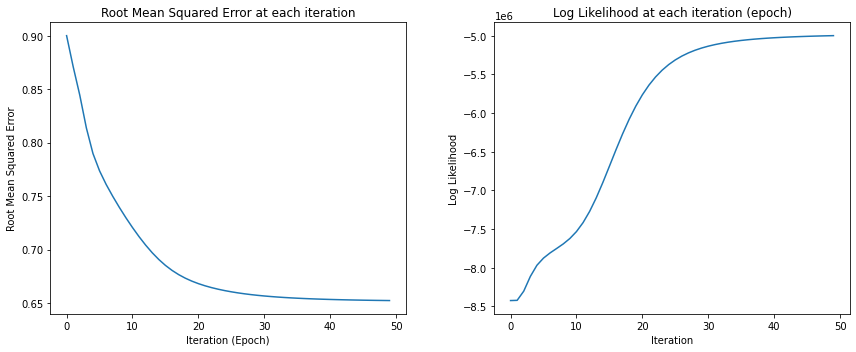

In [65]:
# create a subplot with 2 columns and 1 row
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
# plot the root mean squared error at each iteration
axes[0].plot(range(num_iterations), RMSE)
axes[0].set_xlabel('Iteration (Epoch)')
axes[0].set_ylabel('Root Mean Squared Error')
axes[0].set_title('Root Mean Squared Error at each iteration')
# plot the log likelihood at each iteration
axes[1].plot(range(num_iterations), LOGLOG)
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Log Likelihood')
axes[1].set_title('Log Likelihood at each iteration (epoch)')
plt.tight_layout()
# adjust the subplot layout to favor space between subplots
plt.subplots_adjust(wspace=0.25, hspace=2)
plt.show()

In [65]:
# load the user biases, item biases, user factors and item factors
user_bias = np.load('../data/biases/25m-dataset/user_bias_25m.npy')
item_bias = np.load('../data/biases/25m-dataset/item_bias_25m.npy')
user_factors = np.load('../data/biases/25m-dataset/user_factors_25m.npy')
item_factors = np.load('../data/biases/25m-dataset/item_factors_25m.npy')   

In [57]:
n_items = ratings_new['movieId'].nunique()
n_users = ratings_new['userId'].nunique()

In [58]:
# calculate the predictions
predictions = np.zeros((n_users, n_items))
for user in range(n_users):
    for movie in range(n_items):
        predictions[user, movie] = user_bias[user] + item_bias[movie] + np.dot(user_factors[user], item_factors[movie])

Root Mean Squared Error for the test set: 0.7792237839411703


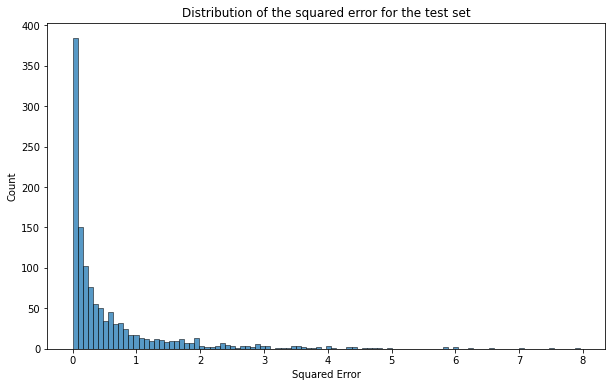

In [66]:
# make predictions for the test set
predictions_test = []
for user, movie, rating in users_test:
    predictions_test.append(user_bias[user] + item_bias[movie] + np.dot(user_factors[user], item_factors[movie]))

# calculate the root mean squared error for the test set
rmse_test = np.sqrt(np.mean([(predictions_test[i] - rating)**2 for i, (user, movie, rating) in enumerate(users_test)]))
print(f'Root Mean Squared Error for the test set: {rmse_test}')

# # plot the distribution of the predictions
# plt.figure(figsize=(10, 6))
# sns.histplot(predictions.flatten(), kde=False, bins=100)
# plt.xlabel('Predictions')
# plt.ylabel('Count')
# plt.title('Distribution of the predictions')
# plt.show()

# # plot the RMSE for the test set
plt.figure(figsize=(10, 6))
sns.histplot([(predictions_test[i] - rating)**2 for i, (user, movie, rating) in enumerate(users_test)], kde=False, bins=100)
plt.xlabel('Squared Error')
plt.ylabel('Count')
plt.title('Distribution of the squared error for the test set')
plt.show()

/Users/prestongovender/miniforge3/envs/tf_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


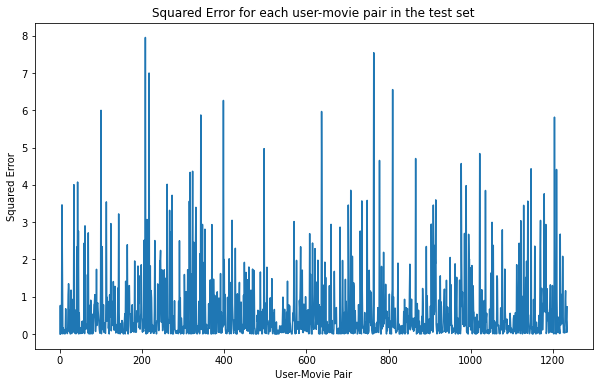

In [67]:
#plot the rmse for the test set line plot

# plot the RMSE for the test set
plt.figure(figsize=(10, 6))
sns.lineplot(range(len(users_test)), [(predictions_test[i] - rating)**2 for i, (user, movie, rating) in enumerate(users_test)])
plt.xlabel('User-Movie Pair')
plt.ylabel('Squared Error')
plt.title('Squared Error for each user-movie pair in the test set')
plt.show()


Calculating best minimal value for power law fit


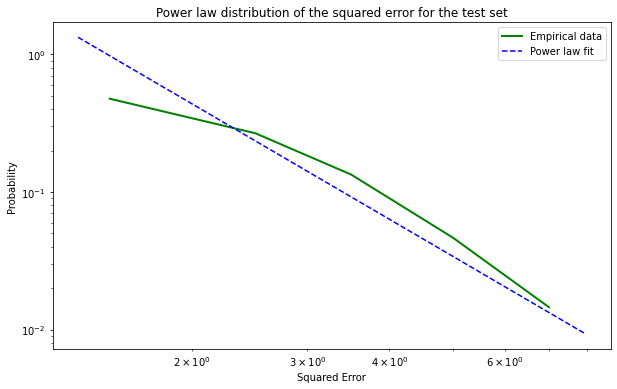

In [68]:
# plot the distribution of the RMSE for the test set
plt.figure(figsize=(10, 6))
# sns.histplot([(predictions_test[i] - rating)**2 for i, (user, movie, rating) in enumerate(users_test)], kde=False, bins=100)
# plt.xlabel('Squared Error')
# plt.ylabel('Count')
# plt.title('Distribution of the squared error for the test set')
# fit the histogram
fit = powerlaw.Fit([(predictions_test[i] - rating)**2 for i, (user, movie, rating) in enumerate(users_test)])
fit.plot_pdf(color='g', linewidth=2)
fit.power_law.plot_pdf(color='b', linestyle='--', ax=plt.gca())
plt.legend(['Empirical data', 'Power law fit'])
plt.xlabel('Squared Error')
plt.ylabel('Probability')
plt.title('Power law distribution of the squared error for the test set')
plt.show()



In [96]:
# get a random user from the training set
user = np.random.choice(n_users)
# make predictions for the user
predictions_user = []
for movie in range(n_items):
    predictions_user.append(user_bias[user] + item_bias[movie] + np.dot(user_factors[user], item_factors[movie]))
# get the top 10 movieIds with the highest predictions
top_movies = np.argsort(predictions_user)[-10:]
# get the titles of the top 10 movies that the user has rated
top_movies = movies_new[movies_new['movieId'].isin(top_movies)]['title'].values.tolist()

Predicted Top 10 movieIds with the highest predictions:
1. Fargo (1996)
2. Roman Holiday (1953)
3. 42 Up (1998)
4. Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)
5. Eternal Sunshine of the Spotless Mind (2004)
6. Paradise Lost 2: Revelations (2000)
7. Connections (1978)
8. O.J.: Made in America (2016)
9. Planet Earth II (2016)
10. Ali Baba Bunny (1957)


Top 10 movieIds with the highest ratings:
1. Toy Story (1995)
2. Jumanji (1995)
3. Grumpier Old Men (1995)
4. Waiting to Exhale (1995)
5. Father of the Bride Part II (1995)
6. Heat (1995)
7. Sabrina (1995)
8. Tom and Huck (1995)
9. Sudden Death (1995)
10. GoldenEye (1995)
11. American President, The (1995)
12. Dracula: Dead and Loving It (1995)
13. Balto (1995)
14. Nixon (1995)
15. Cutthroat Island (1995)
16. Casino (1995)
17. Sense and Sensibility (1995)
18. Four Rooms (1995)
19. Ace Ventura: When Nature Calls (1995)
20. Money Train (1995)


In [200]:
# get a random user from the test set
n_users_test = len(users_test)
user_test = np.random.choice(n_users_test)

In [201]:
# make predictions for the user
predictions_user_test = []
for movie in range(n_items):
    predictions_user_test.append(user_bias[user_test] + item_bias[movie] + np.dot(user_factors[user_test], item_factors[movie]))
# get the top 10 movieIds with the highest predictions
top_movies_test = np.argsort(predictions_user_test)[-10:]
# get the title of the top 10 movies with the highest predictions
top_movies_test = movies_new[movies_new['movieId'].isin(top_movies_test)]['title'].values.tolist()
print("\n")
print(f'Predicted Top 10 movieIds with the highest predictions for user:{user_test}')
for i, movie in enumerate(top_movies_test):
    print(f'{i+1}. {movie}')




Predicted Top 10 movieIds with the highest predictions for user:978
1. Wallace & Gromit: The Best of Aardman Animation (1996)
2. Monty Python and the Holy Grail (1975)
3. Wallace & Gromit: The Wrong Trousers (1993)
4. Princess Bride, The (1987)
5. For All Mankind (1989)
6. Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)
7. Great Beauty, The (Grande Bellezza, La) (2013)
8. Band of Brothers (2001)
9. Planet Earth II (2016)
10. Cosmos


In [202]:
# check what movies the user has rated in the test set
# return the top 10 movies from df for user = user_test
movies_rated = df[df['userId'] == user_test].sort_values('rating', ascending=False)['title'].values.tolist()
print("\n")
print(f'Movies rated by user:{user_test}')
for i, movie in enumerate(movies_rated):
    print(f'{i+1}. {movie}')
    



Movies rated by user:978
1. Napoleon Dynamite (2004)
2. Monty Python and the Holy Grail (1975)
3. Wallace & Gromit: A Close Shave (1995)
4. King of Kong, The (2007)
5. Wallace & Gromit: The Wrong Trousers (1993)
6. Wallace & Gromit: The Best of Aardman Animation (1996)
7. Memento (2000)
8. Italian Job, The (2003)
9. School of Rock (2003)
10. Life Is Beautiful (La Vita è bella) (1997)
11. Interstellar (2014)
12. Grand Day Out with Wallace and Gromit, A (1989)
13. Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966)
14. Princess Bride, The (1987)
15. Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
16. Let the Right One In (Låt den rätte komma in) (2008)
17. The Lego Movie (2014)
18. Inception (2010)
19. Singin' in the Rain (1952)
20. Skyfall (2012)
21. Pursuit of Happyness, The (2006)
22. Star Trek Into Darkness (2013)
23. Sherlock Holmes: A Game of Shadows (2011)
24. O Brother, Where Art Thou? (2000)
25. Big Hero 6 (2014)
26. Up (2009)
27. Godfather: Part II, The (1974)

In [203]:
# return the top 10 movies from top_movies_test that the user has not rated in movies_rated
top_movies_recommendation = [movie for movie in top_movies_test if movie not in movies_rated]

In [204]:
for i, movie in enumerate(top_movies_recommendation):
    print(f'{i+1}. {movie}')

1. For All Mankind (1989)
2. Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)
3. Great Beauty, The (Grande Bellezza, La) (2013)
4. Band of Brothers (2001)
5. Planet Earth II (2016)
6. Cosmos


In [213]:
# get the movie index for Napoleon Dynamite (2004)
movie_index = movies_new[movies_new['title'] == 'Napoleon Dynamite (2004)'].index[0]
print(f'Movie index for Napoleon Dynamite (2004): {movie_index}')

Movie index for Napoleon Dynamite (2004): 7750


In [219]:
#get the movie index for Toy Story (1995)
movie_index = movies_new[movies_new['title'] == 'Toy Story (1995)'].index[0]
print(f'Movie index for Toy Story (1995): {movie_index}')

Movie index for Toy Story (1995): 0


In [220]:
# get the movie index for Lord of the Rings: The Fellowship of the Ring, The (2001)
movie_index = movies_new[movies_new['title'] == 'Lord of the Rings: The Fellowship of the Ring, The (2001)'].index[0]
print(f'Movie index for Lord of the Rings: The Fellowship of the Ring, The (2001): {movie_index}')

Movie index for Lord of the Rings: The Fellowship of the Ring, The (2001): 4887


In [237]:
# get the movie index for Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)
movie_index = movies_new[movies_new['title'] == "Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)"].index[0]
print(f'Movie index for Harry Potter and the Sorcerer\'s Stone (a.k.a. Harry Potter and the Philosopher\'s Stone) (2001): {movie_index}')


Movie index for Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001): 4790


In [251]:
# get the movie index for scooby doo
movie_index = movies_new[movies_new['title'] == "Scooby-Doo (2002)"].index[0]
print(f'Movie index for Scooby-Doo (2002): {movie_index}')


Movie index for Scooby-Doo (2002): 5311


In [252]:
# create a fake test user that has only watched the movie with movieId=0 and rated it 5

n_users = ratings_new['userId'].nunique()
n_items = ratings_new['movieId'].nunique()

fake_user = [(0, 5311, 5)]
lambda_value = 0.05

user_bias_fake = np.zeros(n_users)

# Initialize factor matrices
user_factors_fake = np.random.normal(scale=1/num_factors, size=(n_users, num_factors))

item_bias_updated = item_bias.copy()
item_factors_updated = item_factors.copy()

# calculate user biases and item biases for the fake user
for user, movie, rating in fake_user:
    prediction = user_bias_fake[user] + item_bias[movie] + np.dot(user_factors_fake[user], item_factors[movie])
    error = rating - prediction
    user_bias_fake[user] += lambda_value * (error - lambda_value * user_bias[user])
    user_factors_fake[user] += lambda_value * (error * item_factors[movie] - lambda_value * user_factors[user])
    item_bias_updated[movie] += lambda_value * (error - lambda_value * item_bias[movie])
    item_factors_updated[movie] += lambda_value * (error * user_factors_fake[user] - lambda_value * item_factors[movie])

# make predictions for the fake user
predictions_fake_user = []
for movie in range(n_items):
    predictions_fake_user.append(user_bias_fake[user] + item_bias_updated[movie] + np.dot(user_factors_fake[user], item_factors_updated[movie]))
# get the top 10 movieIds with the highest predictions
top_movies_fake_user = np.argsort(predictions_fake_user)[-10:]
# get the title of the top 10 movies with the highest predictions
top_movies_fake_user = movies_new[movies_new['movieId'].isin(top_movies_fake_user)]['title'].values.tolist()
print("\n")
print(f'Predicted Top 10 movieIds with the highest predictions for fake user and movie:  ')
for i, movie in enumerate(top_movies_fake_user):
    print(f'{i+1}. {movie}')




Predicted Top 10 movieIds with the highest predictions for fake user and movie:  
1. Das Experiment (Experiment, The) (2001)
2. Debt, The (Dlug) (1999)
3. Year of the Hare, The (Jäniksen vuosi) (1977)
4. Great Beauty, The (Grande Bellezza, La) (2013)
5. The Heart of the World (2000)
6. I, Claudius (1976)
7. Planet Earth (2006)
8. Tanna (2015)
9. Band of Brothers (2001)
10. Planet Earth II (2016)


# 5. Model Evaluation: Biases

In [108]:
# make predictions for user 0
user_0_predictions = user_bias[0] + item_bias + user_factors[0, :].dot(item_factors.T)

# print the predicted ratings for user 0
user_0_predictions

# print the actual ratings for user 0
top_0_movies = ratings_new[ratings_new['userId'] == 0].sort_values('rating', ascending=False)

# return the movie titles of top_0_movies
top_0_movies = movies_new[movies_new['movieId'].isin(top_0_movies['movieId'])]

In [109]:
user_0_predictions

array([3.02500752, 2.38305981, 2.26459332, ..., 2.8777042 , 3.5320841 ,
       3.09588877])

In [110]:
top_0_movies

movieId                                              title  \
292       289                                Pulp Fiction (1994)   
302       299   Three Colors: Red (Trois couleurs: Rouge) (1994)   
303       300   Three Colors: Blue (Trois couleurs: Bleu) (1993)   
654       641                                 Underground (1995)   
878       859                         Singin' in the Rain (1952)   
...       ...                                                ...   
9122     8447                                      Taxi 2 (2000)   
9145     8456                                        2046 (2004)   
9306     8568  Very Long Engagement, A (Un long dimanche de f...   
9647     8840                                         5x2 (2004)   
9780     8938                Look at Me (Comme une image) (2004)   

                            genres  num_genres  
292    Comedy|Crime|Drama|Thriller           4  
302                          Drama           1  
303                          Drama           1  
654               Comedy|Drama|War           3  
878         Comedy|Musical|Romance           3  
...                            ...         ...  
9122                 Action|Comedy           2  
9145  Drama|Fantasy|Romance|Sci-Fi           4  
9306     Drama|Mystery|Romance|War           4  
9647                 Drama|Romance           2  
9780          Comedy|Drama|Romance           3  

[70 rows x 4 columns]

In [111]:
# get the top 10 movie recommendations for user 0
top_10_recommendations = np.argsort(user_0_predictions)[::-1][0:10]
# return the movie titles of the top 10 recommendations
movies_new[movies_new['movieId'].isin(top_10_recommendations)]['title']

95                                 Hate (Haine, La) (1995)
600                                           Fargo (1996)
1062                                 Reservoir Dogs (1992)
1201                          Boot, Das (Boat, The) (1981)
5655                               Teddy Bear (Mis) (1981)
12575                             Absolute Giganten (1999)
13347    Jeanne Dielman, 23 Quai du Commerce, 1080 Brux...
16291                                   Connections (1978)
18247                   Beasts of the Southern Wild (2012)
33850                     Billy Elliot: The Musical (2014)
Name: title, dtype: object

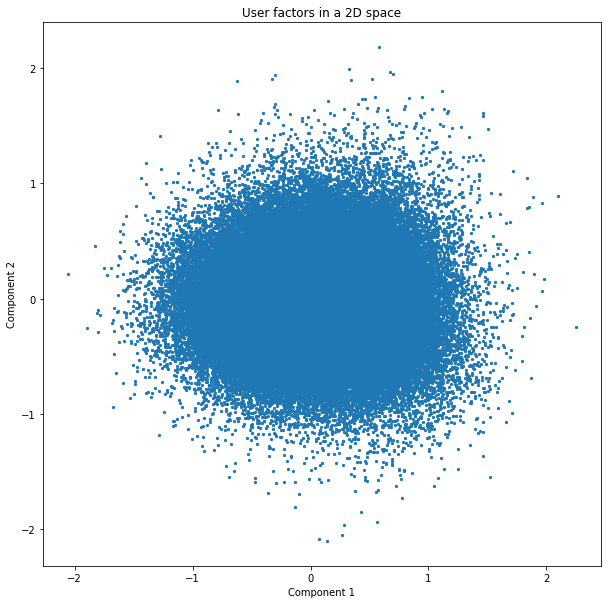

In [113]:
# plot the user factors in a 2D space
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
user_factors_2d = pca.fit_transform(user_factors)
plt.figure(figsize=(10, 10))
plt.scatter(user_factors_2d[:, 0], user_factors_2d[:, 1], s=5)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('User factors in a 2D space')
plt.show()


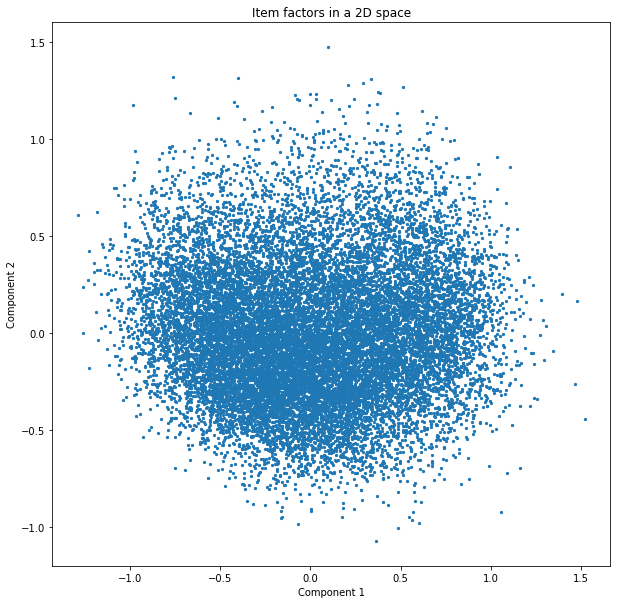

In [114]:
# plot the item factors in a 2D space
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
item_factors_2d = pca.fit_transform(item_factors)
plt.figure(figsize=(10, 10))
plt.scatter(item_factors_2d[:, 0], item_factors_2d[:, 1], s=5)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Item factors in a 2D space')
plt.show()

In [143]:
# create a list of genres
genres = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Documentary', 'Thriller', 'Horror']
# return df where the genres column contains the genre
df_filtered = df[df['genres'].str.contains('|'.join(genres))]
df_filtered

# get the item factors for the movies in df_filtered
item_factors_filtered = item_factors[df_filtered['movieId'].unique()]

In [144]:
item_factors_filtered

array([[ 0.05911002,  0.02887071,  0.06803441, ...,  0.04594168,
        -0.02701385,  0.00290468],
       [ 0.07227887,  0.02127849,  0.04464584, ...,  0.08165335,
        -0.00506813, -0.10839574],
       [ 0.05548805,  0.07288351,  0.03993436, ..., -0.00464937,
         0.00068418,  0.00156898],
       ...,
       [ 0.00441664, -0.00122221,  0.03212596, ...,  0.05366014,
        -0.04524706, -0.04177054],
       [ 0.08818807,  0.01716547, -0.02762823, ..., -0.0205331 ,
        -0.05205763, -0.08237377],
       [ 0.00224095,  0.06389127, -0.06896578, ...,  0.04065701,
        -0.01028669,  0.08267906]])

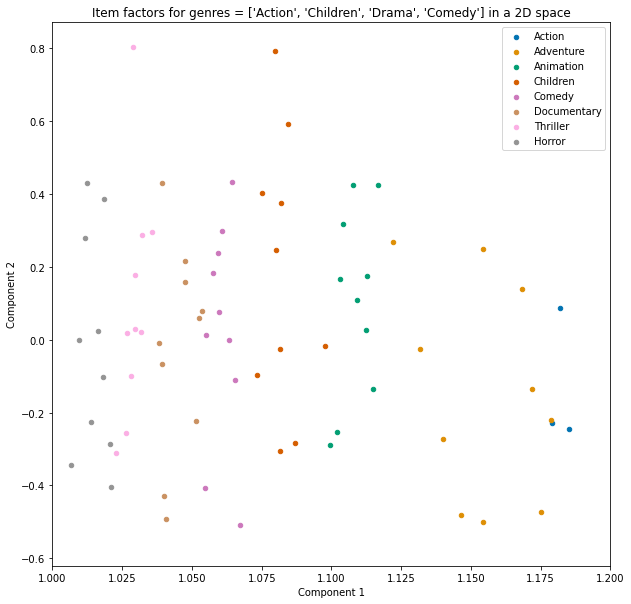

In [148]:
# plot the item factors for genres = ['Action', 'Children', 'Drama', 'Comedey'] in a 2D space
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
genres_2d = pca.fit_transform(item_factors_filtered)
# select 10 top movies for each genre
genres_2d = genres_2d[np.argsort(genres_2d[:, 0])][::-1]
# plot the item factors for genres = ['Action', 'Children', 'Drama', 'Comedey'] in a 2D space
plt.figure(figsize=(10, 10))
# use colorblind palette
sns.set_palette('colorblind')
# create a scatter plot with different colors for each genre
for i, genre in enumerate(genres):
    plt.scatter(genres_2d[i*10:(i+1)*10, 0], genres_2d[i*10:(i+1)*10, 1], s=20, label=genre)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Item factors for genres = [\'Action\', \'Children\', \'Drama\', \'Comedy\'] in a 2D space')
plt.xlim(1, 1.2)
plt.legend()
plt.show()

In [253]:
# get a list of the top 10 genres with the highest number of movies
top_genres = movies_new['genres'].str.split('|').apply(pd.Series).stack().value_counts().head(10).index.tolist()
top_genres

['Drama',
 'Comedy',
 'Thriller',
 'Romance',
 'Action',
 'Crime',
 'Horror',
 'Adventure',
 'Sci-Fi',
 'Fantasy']

In [255]:
# get the item factors for the top 10 genres
item_factors_top_genres = item_factors[movies_new[movies_new['genres'].str.contains('|'.join(top_genres))]['movieId'].unique()]

In [256]:
item_factors_top_genres

array([[-0.02523078,  0.1048007 ,  0.0862712 , ..., -0.00080161,
        -0.05765479, -0.00620635],
       [ 0.05073815,  0.09951117, -0.01719759, ...,  0.01097794,
        -0.01434313,  0.02726342],
       [ 0.06150714,  0.0585713 ,  0.00901086, ...,  0.04521369,
         0.00394194, -0.03059068],
       ...,
       [ 0.07059971,  0.04009034, -0.02491765, ..., -0.05879786,
         0.00908211,  0.00236729],
       [ 0.01782558,  0.02883075, -0.03194355, ..., -0.01006543,
        -0.00765084,  0.00802032],
       [ 0.00939479,  0.03644109, -0.00317155, ...,  0.01714492,
        -0.00071383, -0.02158926]])

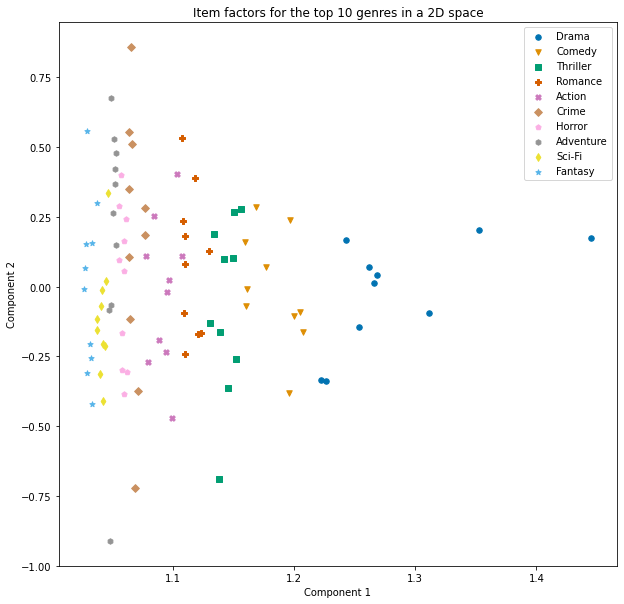

In [259]:
# plot the item factors for the top 10 genres in a 2D space
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
genres_2d = pca.fit_transform(item_factors_top_genres)
# select 10 top movies for each genre
genres_2d = genres_2d[np.argsort(genres_2d[:, 0])][::-1]
# plot the item factors for the top 10 genres in a 2D space
plt.figure(figsize=(10, 10))
# use colorblind palette
sns.set_palette('colorblind')
# create a scatter plot with different colors and shapes for each genre
# create a list of markers
markers = ['o', 'v', 's', 'P', 'X', 'D', 'p', 'h', 'd', '*']
for i, genre in enumerate(top_genres):
    plt.scatter(genres_2d[i*10:(i+1)*10, 0], genres_2d[i*10:(i+1)*10, 1], s=30, label=genre, marker=markers[i])
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Item factors for the top 10 genres in a 2D space')
# plt.xlim(1, 1.2)
plt.legend()
plt.show()

# 6. Model Building: Biases and Genre's

In [69]:
# use Jaccard similarity to calculate the similarity between movies
from sklearn.metrics import jaccard_score

# create a dictionary to store the similarity between movies
movie_similarities = {}
# create a list to store the similarity between movie1 and all other movies
similarities = []

# loop through each movie
for movieId1, genre1 in genres:
    # loop through each movie again
    for movieId2, genre2 in genres:
        # calculate the similarity between movie1 and movie2
        similarity = jaccard_score(genre1, genre2)
        # append the similarity to the similarities list
        similarities.append((movieId1, movieId2, similarity))

KeyboardInterrupt: 

In [100]:
similarities[:10]

{0: [1.0,
  0.6,
  0.16666666666666666,
  0.0,
  0.16666666666666666,
  0.14285714285714285,
  0.0,
  0.2,
  0.25,
  0.0,
  0.16666666666666666,
  0.16666666666666666,
  0.3333333333333333,
  0.0,
  0.25,
  0.6,
  0.2,
  0.125,
  0.14285714285714285,
  0.2857142857142857,
  0.0,
  0.2,
  0.2,
  0.14285714285714285,
  0.0,
  0.4,
  0.125,
  0.125,
  0.0,
  0.16666666666666666,
  0.0,
  0.0,
  0.14285714285714285,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.14285714285714285,
  0.125,
  0.16666666666666666,
  0.375,
  0.14285714285714285,
  0.4,
  0.0,
  0.2,
  0.0,
  0.3333333333333333,
  0.16666666666666666,
  0.2,
  0.0,
  0.0,
  0.16666666666666666,
  0.2,
  0.16666666666666666,
  0.0,
  0.2,
  0.0,
  0.5,
  0.2857142857142857,
  0.2,
  0.4,
  0.0,
  0.14285714285714285,
  0.125,
  0.25,
  0.3333333333333333,
  0.6666666666666666,
  0.16666666666666666,
  0.8333333333333334,
  0.2,
  0.6,
  0.16666666666666666,
  0.2,
  0.6,
  0.16666666666666666,
  0.2,
  0.0,
  0.2,
  0.142857142

In [ ]:
# multiply the last entry of each similarity tuple by 5 to scale the similarity between 1 and 5
movie_similarities = [(movieId1, movieId2, similarity * 5) for movieId1, movieId2, similarity in similarities]

In [ ]:
# save the movie_similarities
np.save('../data/biases/25m-dataset/movie_similarities.npy', movie_similarities)

In [ ]:
movie_similarities[:10]

In [ ]:
similarities[:10]

In [316]:
# calculate the predictions for the test set
prediction_test = []
for user, movie, rating in users_test:
    # calculate the prediction for each user-movie pair
    predictions = user_bias[user] + item_bias[movie] + np.dot(user_factors[user], item_factors[movie])
    # append the prediction to the prediction_test list
    prediction_test.append((user, movie, predictions))

In [ ]:
# use Jaccard similarity to calculate the similarity between movies
from sklearn.metrics import jaccard_score
genres_item_list = [genre[0] for genre in genres]

# create a list to store the similarity between movie1 and all other movies
similarities = []

# # sort the prediction_test list by movieId
# prediction_test = sorted(prediction_test, key=lambda x: x[1])

for user, movie, prediction in prediction_test:
    if movie in genres_item_list:
        # loop through each movie again
        for movieId2, genre2 in genres:
            # calculate the similarity between movie1 and movie2
            similarity = jaccard_score(genres[movie][1], genre2)
            # append the similarity to the similarities list
            similarities.append((movieId1, movieId2, similarity))

In [221]:
prediction_test

[(166, 1184, 3.4550116864762104),
 (292, 57, 4.125301160104969),
 (456, 3011, 4.022883337677408),
 (677, 12939, 4.16180794202685),
 (687, 8666, 3.659293004397555),
 (757, 1911, 3.139296139423207),
 (791, 841, 3.766479702318774),
 (869, 13983, 3.948310626725429),
 (911, 1407, 3.0934171991312738),
 (965, 1225, 3.7872453407051188),
 (1161, 572, 2.842390382468362),
 (1355, 2789, 3.7018390997710946),
 (1359, 1329, 4.0192086621411836),
 (1518, 4871, 4.1310950435208085),
 (1911, 1223, 4.178034691809424),
 (2374, 10655, 3.8144470780352107),
 (2537, 1814, 3.630884714400702),
 (2865, 2533, 3.283127791485802),
 (2885, 5653, 3.898926824048492),
 (2910, 5159, 4.373403807919644),
 (2929, 10550, 2.973829882402965),
 (3081, 876, 4.1608261498771455),
 (3298, 577, 3.0728288918279896),
 (3312, 1046, 4.7635001208453875),
 (3332, 8936, 3.1944073540753326),
 (3719, 14595, 3.429516044017793),
 (3746, 3435, 3.961049315373442),
 (4213, 1313, 3.4152452117816487),
 (4338, 3087, 4.705511436408324),
 (4344, 6715, 

In [215]:
prediction_test_users

[166,
 292,
 456,
 677,
 687,
 757,
 791,
 869,
 911,
 965,
 1161,
 1355,
 1359,
 1518,
 1911,
 2374,
 2537,
 2865,
 2885,
 2910,
 2929,
 3081,
 3298,
 3312,
 3332,
 3719,
 3746,
 4213,
 4338,
 4344,
 4377,
 5205,
 5513,
 5868,
 5897,
 5974,
 5977,
 6036,
 6197,
 6274,
 6342,
 6342,
 6568,
 6757,
 7102,
 7327,
 7466,
 7511,
 7516,
 7857,
 7935,
 7957,
 8168,
 8270,
 8463,
 8515,
 8539,
 8546,
 8695,
 8929,
 8943,
 8962,
 8969,
 9093,
 9140,
 9386,
 9401,
 9550,
 9794,
 10541,
 10558,
 10575,
 10776,
 10782,
 10928,
 10935,
 10964,
 10967,
 10968,
 10986,
 11331,
 11410,
 11621,
 11740,
 11743,
 11766,
 11834,
 11865,
 11866,
 11890,
 11967,
 11986,
 12053,
 12089,
 12164,
 12245,
 12405,
 12421,
 12568,
 12612,
 12612,
 12698,
 12794,
 12854,
 13030,
 13034,
 13283,
 13283,
 13285,
 13634,
 13943,
 14091,
 14292,
 14505,
 14515,
 14553,
 14594,
 14666,
 14779,
 14903,
 14923,
 15010,
 15231,
 15463,
 15854,
 15971,
 16001,
 16159,
 16179,
 16188,
 16496,
 16902,
 16957,
 17205,
 17205,

In [293]:
# select a random user from the test set
prediction_test_users = [user for user, movie, prediction in prediction_test]
user = 135337 #np.random.choice(prediction_test_users)

# use Jaccard similarity to calculate the similarity between movies
from sklearn.metrics import jaccard_score
genres_item_list = [genre[0] for genre in genres]

# create a list to store the similarity between movie1 and all other movies
similarities = []

# # sort the prediction_test list by movieId
# prediction_test = sorted(prediction_test, key=lambda x: x[1])

# return the (userId, movieId, prediction) for the selected user
prediction_test_user = [(userid, movie, prediction) for userid, movie, prediction in prediction_test if userid == user]

# get the similarity between the movies in the prediction_test_user list
for user, movie, prediction in prediction_test_user:
    if movie in genres_item_list:
        # loop through each movie again
        for movieId2, genre2 in genres:
            # calculate the similarity between movie1 and movie2
            similarity = jaccard_score(genres[movie][1], genre2)
            # append the similarity to the similarities list
            similarities.append((movieId1, movieId2, similarity))

# return the top 10 similar movies for the selected user
top_10_similar_movies = sorted(similarities, key=lambda x: x[2], reverse=True)[:10]

# scale the similarity between 1 and 5
top_10_similar_movies = [(movieId1, movieId2, similarity) for movieId1, movieId2, similarity in top_10_similar_movies]

# 135337 10558

In [294]:
# print the title for the movie in prediction_test_user
print(f'Movies rated by user:{user}')
for i, (userid, movie, prediction) in enumerate(prediction_test_user):
    print(f'{i+1}. {movies_new[movies_new["movieId"] == movie]["title"].values[0]}')
    

Movies rated by user:135337
1. Harry Potter and the Order of the Phoenix (2007)


In [295]:
n_items = ratings_new['movieId'].nunique()
# make predictions for the specified user
predictions_user = []
for movie in range(n_items):
    predictions_user.append(user_bias[user] + item_bias[movie] + np.dot(user_factors[user], item_factors[movie]))

# get the top 10 movieIds with the highest predictions
top_movies_user = np.argsort(predictions_user)[-10:]
# get the title of the top 10 movies with the highest predictions
top_movies_user = movies_new[movies_new['movieId'].isin(top_movies_user)]['title'].values.tolist()
print("\n")
print(f'Predicted Top 10 movieIds with the highest predictions for user:{user}')
for i, movie in enumerate(top_movies_user):
    print(f'{i+1}. {movie}')
    



Predicted Top 10 movieIds with the highest predictions for user:135337
1. Reservoir Dogs (1992)
2. Princess Mononoke (Mononoke-hime) (1997)
3. Green Mile, The (1999)
4. Dear Zachary: A Letter to a Son About His Father (2008)


In [309]:
# incorporate the similarity between movies into the predictions
# make predictions for the specified user
predictions_user = []
for movie in range(n_items):
    # get the similarity between the movie and the top 10 similar movies
    similarity = [similarity for movieId1, movieId2, similarity in top_10_similar_movies if movieId2 == movie]
    # if the movie is in the top 10 similar movies, calculate the prediction
    if len(similarity) > 0:
        predictions_user.append(user_bias[user] + item_bias[movie] + np.dot(user_factors[user], item_factors[movie]) + 5*similarity[0])
    # if the movie is not in the top 10 similar movies, calculate the prediction without the similarity
    else:
        predictions_user.append(user_bias[user] + item_bias[movie] + np.dot(user_factors[user], item_factors[movie]))

# get the top 10 movieIds with the highest predictions
top_movies_user = np.argsort(predictions_user)[-10:]
# get the title of the top 10 movies with the highest predictions
top_movies_user = movies_new[movies_new['movieId'].isin(top_movies_user)]['title'].values.tolist()
print("\n")
print(f'Predicted Top 10 movieIds with the highest predictions for user:{user}')
for i, movie in enumerate(top_movies_user):
    print(f'{i+1}. {movie}')



Predicted Top 10 movieIds with the highest predictions for user:157812
1. Apollo 13 (1995)
2. Clan of the Cave Bear, The (1986)
3. Harry Potter and the Prisoner of Azkaban (2004)
4. Sophie's World (Sofies verden) (1999)
5. Valerie and Her Week of Wonders (Valerie a týden divu) (1970)
6. Nibelungen: Siegfried, Die (1924)
7. Harry Potter and the Order of the Phoenix (2007)
8. Spiderwick Chronicles, The (2008)
9. Where the Wild Things Are (2009)
10. Thor (2011)


In [317]:
# calculate the predictions for the test set with the similarity between movies incorporated
prediction_test = []
for user, movie, rating in users_test:
    # get the similarity between the movie and the top 10 similar movies
    similarity = [similarity for movieId1, movieId2, similarity in top_10_similar_movies if movieId2 == movie]
    # if the movie is in the top 10 similar movies, calculate the prediction
    if len(similarity) > 0:
        prediction_test.append((user, movie, user_bias[user] + item_bias[movie] + np.dot(user_factors[user], item_factors[movie]) + 2*similarity[0]))
    # if the movie is not in the top 10 similar movies, calculate the prediction without the similarity
    else:
        prediction_test.append((user, movie, user_bias[user] + item_bias[movie] + np.dot(user_factors[user], item_factors[movie])))

# calculate the root mean squared error for the test set
rmse_test = np.sqrt(np.mean([(prediction - rating)**2 for user, movie, rating in prediction_test]))
print(f'Root Mean Squared Error for the test set: {rmse_test}')


Root Mean Squared Error for the test set: 0.7178688005204874


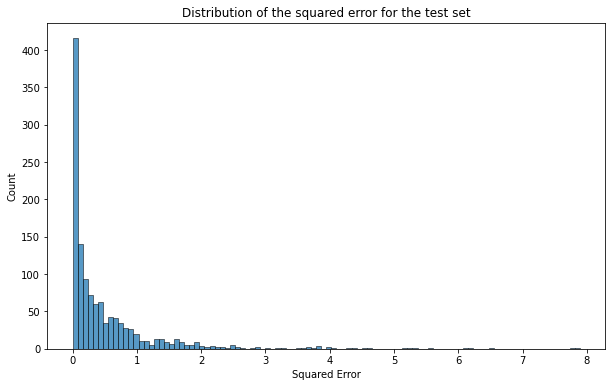

In [318]:
# plot the distribution of the RSME for the test set
plt.figure(figsize=(10, 6))
sns.histplot([(prediction - rating)**2 for user, movie, rating in prediction_test], kde=False, bins=100)
plt.xlabel('Squared Error')
plt.ylabel('Count')
plt.title('Distribution of the squared error for the test set')
plt.show()


In [227]:
predictions_user

[3.8560855075922293,
 2.9069794363387875,
 3.05336790355964,
 2.711873374823709,
 2.6022001050419794,
 4.086141848202687,
 3.5449302985008577,
 2.904449976328872,
 2.5183225316582982,
 3.5414845066107463,
 3.648675551638444,
 2.361381152981263,
 3.368275706865354,
 3.6676877545539783,
 2.373672274157024,
 4.076734941797513,
 4.2776531984574255,
 3.729597098783092,
 2.591733641320604,
 2.7693421968518575,
 3.970480227359524,
 3.1942344801444076,
 3.0442624834177976,
 3.466195521248154,
 4.371221133138303,
 4.272739162645897,
 3.0616814411576136,
 4.147848963653411,
 3.8853123477275453,
 3.6295127720065365,
 3.117802673425819,
 4.034862136914702,
 3.2529712206349535,
 3.7478148617181057,
 3.8779670421839754,
 4.555812887607851,
 3.499695757965762,
 2.3625516675919007,
 3.3373921893221525,
 4.04424887011097,
 4.27927929883653,
 3.1450952492668964,
 3.775371368597667,
 2.6172270667806457,
 3.8378033637646185,
 3.305371196032217,
 4.295928307269369,
 3.2092327786686843,
 3.6835604662651362,

In [223]:
prediction_test_user

[(33523, 1303, 3.8211193569155357)]

In [205]:
user

103001

In [206]:
prediction_test_user

[(103001, 1141, 4.517865059219585)]

In [199]:
# return the top 10 similar movies for the selected user
top_10_similar_movies = sorted(similarities, key=lambda x: x[2], reverse=True)[:10]

In [200]:
top_10_similar_movies

[(0, 13, 1.0),
 (0, 25, 1.0),
 (0, 30, 1.0),
 (0, 39, 1.0),
 (0, 42, 1.0),
 (0, 54, 1.0),
 (0, 56, 1.0),
 (0, 61, 1.0),
 (0, 66, 1.0),
 (0, 89, 1.0)]

In [183]:
prediction_test_user

[(7857, 2931, 3.641585338844285)]

In [168]:
similarities

[]

In [166]:
prediction_test

[(166, 1184, 3.4550116864762104),
 (292, 57, 4.125301160104969),
 (456, 3011, 4.022883337677408),
 (677, 12939, 4.16180794202685),
 (687, 8666, 3.659293004397555),
 (757, 1911, 3.139296139423207),
 (791, 841, 3.766479702318774),
 (869, 13983, 3.948310626725429),
 (911, 1407, 3.0934171991312738),
 (965, 1225, 3.7872453407051188),
 (1161, 572, 2.842390382468362),
 (1355, 2789, 3.7018390997710946),
 (1359, 1329, 4.0192086621411836),
 (1518, 4871, 4.1310950435208085),
 (1911, 1223, 4.178034691809424),
 (2374, 10655, 3.8144470780352107),
 (2537, 1814, 3.630884714400702),
 (2865, 2533, 3.283127791485802),
 (2885, 5653, 3.898926824048492),
 (2910, 5159, 4.373403807919644),
 (2929, 10550, 2.973829882402965),
 (3081, 876, 4.1608261498771455),
 (3298, 577, 3.0728288918279896),
 (3312, 1046, 4.7635001208453875),
 (3332, 8936, 3.1944073540753326),
 (3719, 14595, 3.429516044017793),
 (3746, 3435, 3.961049315373442),
 (4213, 1313, 3.4152452117816487),
 (4338, 3087, 4.705511436408324),
 (4344, 6715, 

In [167]:
user

91475

In [165]:
if user in prediction_test_users:
    print("yes")
    print(prediction_test[prediction_test_users.index(user)][2])# = prediction_test[prediction_test_users.index(user)][2] + similarity * prediction

yes
3.773289747742597


In [158]:


# get the predictions for the user [(user, movie, rating), ...]
for user in prediction_test_users:
    predictions = [prediction for user, movie, prediction in prediction_test if user == user]


True

In [145]:
similarities

[]

In [ ]:
# get similar movies for movieId=0
similar_movies = [movieId2 for movieId1, movieId2, similarity in similarities if movieId1 == 0]
# get the top 10 similar movies
top_similar_movies = np.argsort(similar_movies)[-10:]
# get the title of the top 10 similar movies
top_similar_movies = movies_new[movies_new['movieId'].isin(top_similar_movies)]['title'].values.tolist()
print("\n")
print(f'Top 10 similar movies for movieId=0')
for i, movie in enumerate(top_similar_movies):
    print(f'{i+1}. {movie}')

In [114]:
similarities[:10]

[]

In [ ]:


# for movie in predictions, get the top 5 movies that are most similar to it
# create a dictionary to store the top 5 movies that are most similar to each movie
top_movies = {}
# loop through each movie
for movieId1, movieId2, similarity in movie_similarities:
    # if movieId1 is not in the dictionary, add it
    if movieId1 not in top_movies:
        top_movies[movieId1] = [(movieId2, similarity)]
    # if movieId1 is in the dictionary, append the movieId2 and similarity to the list
    else:
        top_movies[movieId1].append((movieId2, similarity))

# sort the list of similar movies for each movie in descending order of similarity
for movieId1 in top_movies:
    top_movies[movieId1] = sorted(top_movies[movieId1], key=lambda x: x[1], reverse=True)

# get the top 5 movies that are most similar to each movie
for movieId1 in top_movies:
    top_movies[movieId1] = top_movies[movieId1][:5]

In [ ]:
prediction_test[:10]

In [ ]:
top_movies

In [187]:
# get the similarity between movie 0 and all other movies
movie_similarities[0]

# get the indices of the top 10 similar movies
top_10_indices = np.argsort(movie_similarities[0])[-10:]
# get the movieIds of the top 10 similar movies
top_10_movieIds = [list(new_movieId.keys())[list(new_movieId.values()).index(i)] for i in top_10_indices]
# get the titles of the top 10 similar movies
top_10_titles = movies_new[movies_new['movieId'].isin(top_10_indices)]['title'].values.tolist()
# print the title of movie 0
print(movies_new[movies_new['movieId'] == 0]['title'].values.tolist())

['Toy Story (1995)']


In [ ]:
# prediction for user 0
user_0_predictions = predictions[0]

# prediction for movie 0
movie_0_predictions = user_bias + item_bias[0] + user_factors.dot(item_factors[0, :].T)

In [ ]:
user_0_predictions

array([3.97266767, 2.20873892, 0.6029729 , ..., 4.47228899, 4.42758777,
       4.44526643])

In [ ]:
movie_similarities[0]

[1.0,
 0.6,
 0.16666666666666666,
 0.0,
 0.16666666666666666,
 0.14285714285714285,
 0.0,
 0.2,
 0.25,
 0.0,
 0.16666666666666666,
 0.16666666666666666,
 0.3333333333333333,
 0.0,
 0.25,
 0.6,
 0.2,
 0.125,
 0.14285714285714285,
 0.2857142857142857,
 0.0,
 0.2,
 0.2,
 0.14285714285714285,
 0.0,
 0.4,
 0.125,
 0.125,
 0.0,
 0.16666666666666666,
 0.0,
 0.0,
 0.14285714285714285,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.14285714285714285,
 0.125,
 0.16666666666666666,
 0.375,
 0.14285714285714285,
 0.4,
 0.0,
 0.2,
 0.0,
 0.3333333333333333,
 0.16666666666666666,
 0.2,
 0.0,
 0.0,
 0.16666666666666666,
 0.2,
 0.16666666666666666,
 0.0,
 0.2,
 0.0,
 0.5,
 0.2857142857142857,
 0.2,
 0.4,
 0.0,
 0.14285714285714285,
 0.125,
 0.25,
 0.3333333333333333,
 0.6666666666666666,
 0.16666666666666666,
 0.8333333333333334,
 0.2,
 0.6,
 0.16666666666666666,
 0.2,
 0.6,
 0.16666666666666666,
 0.2,
 0.0,
 0.2,
 0.14285714285714285,
 0.0,
 0.0,
 0.14285714285714285,
 0.0,
 0.0,
 0.0,
 0.0,
 0.1428571428571

### Parallelization

In [337]:
import multiprocessing

multiprocessing.cpu_count()

8

In [68]:
def calculate_user_biases(user, movie, rating):
    prediction = user_bias[user] + item_bias[movie] + np.dot(user_factors[user], item_factors[movie])
    error = rating - prediction
    user_bias[user] += lambda_value * (error - lambda_value * user_bias[user])
    user_factors[user] += lambda_value * (error * item_factors[movie] - lambda_value * user_factors[user])

def calculate_item_biases(movie, user, rating):
    prediction = user_bias[user] + item_bias[movie] + np.dot(user_factors[user], item_factors[movie])
    error = rating - prediction
    item_bias[movie] += lambda_value * (error - lambda_value * item_bias[movie])
    item_factors[movie] += lambda_value * (error * user_factors[user] - lambda_value * item_factors[movie])

def calculate_rmse(user, movie, rating):
    prediction = user_bias[user] + item_bias[movie] + np.dot(user_factors[user], item_factors[movie])
    return (prediction - rating) ** 2

def calculate_loglikelihood(user, movie, rating):
    prediction = user_bias[user] + item_bias[movie] + np.dot(user_factors[user], item_factors[movie])
    return np.log(1 / (1 + np.exp(-prediction)))

In [ ]:
if __name__ == '__main__':
    pool = multiprocessing.Pool(processes=4)

    for _ in range(num_iterations):
        # Calculate user biases in parallel
        user_res = pool.starmap(calculate_user_biases, users)
        user_para = user_res.get()

        # Calculate item biases in parallel
        pool.starmap(calculate_item_biases, movies)

        # Calculate RMSE in parallel
        rmse_results = pool.starmap(calculate_rmse, users)
        rmse = np.sqrt(np.mean(rmse_results))
        RMSE.append(rmse)

        # Calculate log likelihood in parallel
        loglik_results = pool.starmap(calculate_loglikelihood, users)
        loglik = np.sum(loglik_results)
        LOGLOG.append(loglik)
        
        print(f'Iteration: {_} | Root Mean Squared Error: {RMSE[_]} | Log Likelihood: {LOGLOG[_]}')


    pool.close()
    pool.join()

In [ ]:
# parrallelize the code using multiprocessing
from multiprocessing import Pool

# Hyperparameters
num_factors = 1000
lambda_value = 0.1
num_iterations = 50
n_items = ratings_new['movieId'].nunique()
n_users = ratings_new['userId'].nunique()

# Initialize biases
user_bias = np.zeros(n_users)
item_bias = np.zeros(n_items)

# Initialize factor matrices
user_factors = np.random.normal(scale=1/num_factors, size=(n_users, num_factors))
item_factors = np.random.normal(scale=1/num_factors, size=(n_items, num_factors))

# Create lists to store RMSE and log-likelihood for each iteration
RMSE = []
LOGLOG = []

# loop through the number of iterations
for _ in range(num_iterations):
    # loop through each user-movie pair and calculate user biases
    with Pool(4) as p1:
        p1.starmap(calculate_user_biases, users)

    # loop through each user-movie pair and calculate item biases
    with Pool(4) as p2:
        p2.starmap(calculate_item_biases, movies)

    # compute the root mean squared error at each iteration, append it to the rmse list and print it for each iteration
    with Pool(4) as p3:
        rmse_results = p3.starmap(calculate_rmse, users)
    rmse = np.sqrt(np.mean(rmse_results))
    RMSE.append(rmse)

    # compute the log likelihood at each iteration, append it to the loglog list and print it for each iteration
    with Pool(4) as p4:
        loglik_results = p4.starmap(calculate_loglikelihood, users)
    loglik = np.sum(loglik_results)
    LOGLOG.append(loglik)

    print(f'Iteration: {_} | Root Mean Squared Error: {RMSE[_]} | Log Likelihood: {LOGLOG[_]}')



# Digression - Experiment using cosine similarity.

In [50]:
from sklearn.metrics.pairwise import cosine_similarity

In [52]:
ratings_matrix.head()

movieId  1       2       3       4       5       6       7       8       \
userId                                                                    
1           4.0     0.0     4.0     0.0     0.0     4.0     0.0     0.0   
2           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
5           4.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

movieId  9       10      ...  193565  193567  193571  193573  193579  193581  \
userId                   ...                                                   
1           0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
2           0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
3           0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
4           0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
5           0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   

movieId  193583  193585  193587  193609  
userId                                   
1           0.0     0.0     0.0     0.0  
2           0.0     0.0     0.0     0.0  
3           0.0     0.0     0.0     0.0  
4           0.0     0.0     0.0     0.0  
5           0.0     0.0     0.0     0.0  

[5 rows x 9724 columns]

Filling the sparse matrix with zeros is not a good idea. We can use the mean of the ratings as a proxy for the missing values. This is a simple and effective way to fill in the missing values. It will also help us to avoid the problem of overfitting. We will use the `sklearn` library to calculate the mean of the ratings.

In [54]:
# create a function that standardizes each row (user)
def standardize(row):
    new_row = (row - row.mean())/(row.max() - row.min())
    return new_row

# create a new matrix with standardized values
ratings_std = ratings_matrix.apply(standardize)

# calculate the cosine similarity between users
user_similarity = cosine_similarity(ratings_std)

# calculate the cosine similarity between movies
# we take the transpose of the matrix to get the similarity between movies
item_similarity = cosine_similarity(ratings_std.T)
        

In [ ]:
# create a function that returns the most similar users
def get_similar_users(user_id, user_similarity):
    # get the index of the user that matches the user_id
    idx = ratings_matrix.index.get_loc(user_id)
    
    # create a Series with the similarity scores in descending order
    # drop the user's own similarity score
    sim_scores = pd.Series(user_similarity[idx]).sort_values(ascending=False)
    
    # get the user indices
    user_indices = [i for i in sim_scores.index]
    
    # get the top 10 most similar users
    top_users = sim_scores.iloc[1:11].index
    
    # print the user_id and the 10 most similar users
    print('The 10 most similar users for User {} are:)'.format(user_id))
    for i in top_users:
        print(ratings_matrix.index[i])

In [55]:
get_similar_users(1, user_similarity)

The 10 most similar users for User 1 are:)
313
266
57
469
368
452
19
597
217
135


In [56]:
# create a function that returns the most similar movies
def get_similar_movies(movie_id, item_similarity):
    # get the index of the movie that matches the movie_id
    idx = ratings_matrix.columns.get_loc(movie_id)
    
    # create a Series with the similarity scores in descending order
    # drop the movie's own similarity score
    sim_scores = pd.Series(item_similarity[idx]).sort_values(ascending=False)
    
    # get the movie indices
    movie_indices = [i for i in sim_scores.index]
    
    # get the top 10 most similar movies
    top_movies = sim_scores.iloc[1:11].index
    
    # print the movie_id and the 10 most similar movies
    print('The 10 most similar movies for Movie {} are:)'.format(movie_id))
    for i in top_movies:
        print(ratings_matrix.columns[i])

In [57]:
get_similar_movies(1, item_similarity)

The 10 most similar movies for Movie 1 are:)
3114
1265
780
1073
648
788
2355
364
34
4886


In [93]:
# print the movie_id and the 10 most similar movies and their similarity scores with movie titles
def get_similar_movies(movie_id, item_similarity, user_rating):
    # get the index of the movie that matches the movie_id
    idx = ratings_matrix.columns.get_loc(movie_id)
    
    # create a Series with the similarity scores in descending order
    # drop the movie's own similarity score
    sim_scores = pd.Series(item_similarity[idx])
    # scale the similarity scores so that user rating can be considered
    sim_scores = sim_scores * (user_rating-2.5)
    sim_scores = sim_scores.sort_values(ascending=False)
    
    # get the movie indices
    movie_indices = [i for i in sim_scores.index]
    
    # get the top 10 most similar movies
    top_movies = sim_scores.iloc[1:11].index
    
    # print the movie_id and the 10 most similar movies
    print('The 10 most similar movies for Movie {} {} are:)'.format(movie_id, movies[movies['movieId'] == ratings_matrix.columns[idx]]['title'].values[0]))
    for i in top_movies:
        print(ratings_matrix.columns[i], sim_scores[i], movies[movies['movieId'] == ratings_matrix.columns[i]]['title'].values[0])
        
get_similar_movies(356, item_similarity,4)

The 10 most similar movies for Movie 356 Forrest Gump (1994) are:)
480 0.6804485215599689 Jurassic Park (1993)
500 0.6606902061812354 Mrs. Doubtfire (1993)
318 0.6167698303340495 Shawshank Redemption, The (1994)
150 0.5855610032337975 Apollo 13 (1995)
597 0.5852691787933728 Pretty Woman (1990)
110 0.5614109303785232 Braveheart (1995)
296 0.5606638672059776 Pulp Fiction (1994)
364 0.537211883052519 Lion King, The (1994)
377 0.5221630911178504 Speed (1994)
586 0.5134442777352655 Home Alone (1990)


In [110]:
# create a function that takes in a user list of movies and ratings, and returns the top 10 recommended movies for that user
def get_recommendations(user_id, user_similarity, item_similarity):
    # get the index of the user that matches the user_id
    idx = ratings_matrix.index.get_loc(user_id)
    
    # get the user ratings
    user_ratings = ratings_matrix.iloc[idx].values
    
    # create a Series with the movie titles
    movie_titles = ratings_matrix.columns
    
    # create a list to store the similarity scores
    sim_scores = []
    
    # for each movie
    for i in range(len(user_ratings)):
        # if the user has rated the movie
        if user_ratings[i] > 0:
            # for each item in the item_similarity array
            for j in range(len(item_similarity[i])):
                # calculate the similarity score
                sim_scores.append((item_similarity[i][j], movie_titles[j]))
    
    # sort the scores
    sim_scores = sorted(sim_scores, key=lambda x: x[0], reverse=True)
    
    # get the scores of the 10 most similar movies
    sim_scores = sim_scores[:10]
    
    # get the movie indices
    movie_indices = [i[1] for i in sim_scores]


    # print out the top 10 movies that the user has watched with movie titles and ratings
    print('The top 10 movies that User {} has watched are:'.format(user_id))
    for i in ratings_matrix.iloc[idx].sort_values(ascending=False)[:10].index:
        print(i, ratings_matrix.iloc[idx][i], movies[movies['movieId'] == i]['title'].values[0])

        


    # print the top 10 most similar movies
    print('\n')
    print('The top 10 recommended movies for User {}  are:'.format(user_id))
    for i in movie_indices:
        print(i, movies[movies['movieId'] == ratings_matrix.columns[i]]['title'].values[0])

get_recommendations(524, user_similarity, item_similarity)

The top 10 movies that User 524 has watched are:
150 5.0 Apollo 13 (1995)
1200 5.0 Aliens (1986)
1266 5.0 Unforgiven (1992)
1275 5.0 Highlander (1986)
1278 5.0 Young Frankenstein (1974)
494 5.0 Executive Decision (1996)
457 5.0 Fugitive, The (1993)
1242 5.0 Glory (1989)
1291 5.0 Indiana Jones and the Last Crusade (1989)
1303 5.0 Man Who Would Be King, The (1975)


The top 10 recommended movies for User 524  are:
193 Drop Zone (1994)
1208 Air Force One (1997)
485 Tombstone (1993)
1356 Borrowers, The (1997)
10 American President, The (1995)
6 Sabrina (1995)
445 Poetic Justice (1993)
880 Double Life of Veronique, The (Double Vie de Véronique, La) (1991)
151 Mad Love (1995)
457 Romper Stomper (1992)


8

for m=0...M...1:
    numerator = 0
    denominator = alpha

    for (n,r) in get_user_ratings(m):
        numerator += lambda(rating-item_bias[n])**2
        denominator += lambda

    userbias[m] = numerator/denominator

    Parallisation Libraries

for parfor (code)

code(a,b): loop over users a to b